In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import datetime
import scipy
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from feature_engine.timeseries.forecasting import WindowFeatures
from statsmodels.tsa.seasonal import seasonal_decompose
# from hampel import hampel
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from interpret.glassbox import ExplainableBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.ar_model import AutoReg
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from scipy.stats import pearsonr
from scipy.stats import skew
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from lime import lime_tabular
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings

warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
# pusa,-delhi, delhi, india-air-quality

df = pd.read_csv("/Users/dhruv/Dhruv/sem_5/GIS/Review Paper/Research/pusa,-delhi, delhi, india-air-quality.csv", na_values=['NA', 'N/A', ' ', ''])


In [86]:
model_r2_score_list = []
model_error_list = []

In [87]:
df['date'] = pd.to_datetime(df['date'])

# Group data by 6-month periods
df['6_month_group'] = df['date'].dt.to_period('6M')

columns_to_fill = [' pm25',' pm10', ' o3', ' no2', ' so2', ' co']  
def fill_nan_with_mean(group):
    for col in columns_to_fill:
        if group[col].isnull().sum() == len(group):
            group[col].fillna(df[col].mean(), inplace=True)
        else:
            group[col].fillna(group[col].mean(), inplace=True)
    return group

all_accuracy = []
df = df.groupby('6_month_group').apply(fill_nan_with_mean)

df.drop('6_month_group', axis=1, inplace=True)

print(df.isnull().sum())
df['AQI'] = df[columns_to_fill].max(axis=1)
print(df)

date     0
 pm25    0
 pm10    0
 o3      0
 no2     0
 so2     0
 co      0
dtype: int64
           date        pm25    pm10    o3   no2        so2       co  \
0    2023-10-01  149.000000  115.00   8.0  13.0   1.000000   8.0000   
1    2023-10-02  142.000000  132.00   6.0  16.0   1.000000  10.0000   
2    2023-10-03  139.000000  149.00   8.0  18.0   1.000000  11.0000   
3    2023-10-04  145.000000  143.00   7.0  17.0   1.000000  10.0000   
4    2023-10-05  159.000000  137.00   5.0  17.0   1.000000  10.0000   
...         ...         ...     ...   ...   ...        ...      ...   
2097 2018-06-02  149.678571   87.00  56.0  11.0  10.000000   7.0000   
2098 2017-12-31  180.200000  212.00  37.0  14.0   5.688589  11.5776   
2099 2017-11-06  209.210526  280.00  12.0   7.0   5.688589  11.5776   
2100 2017-11-13  209.210526  189.00  29.0  21.0   5.688589  11.5776   
2101 2020-05-10  118.833333   83.25  49.0  10.0   5.688589   6.0000   

             AQI  
0     149.000000  
1     142.000000  


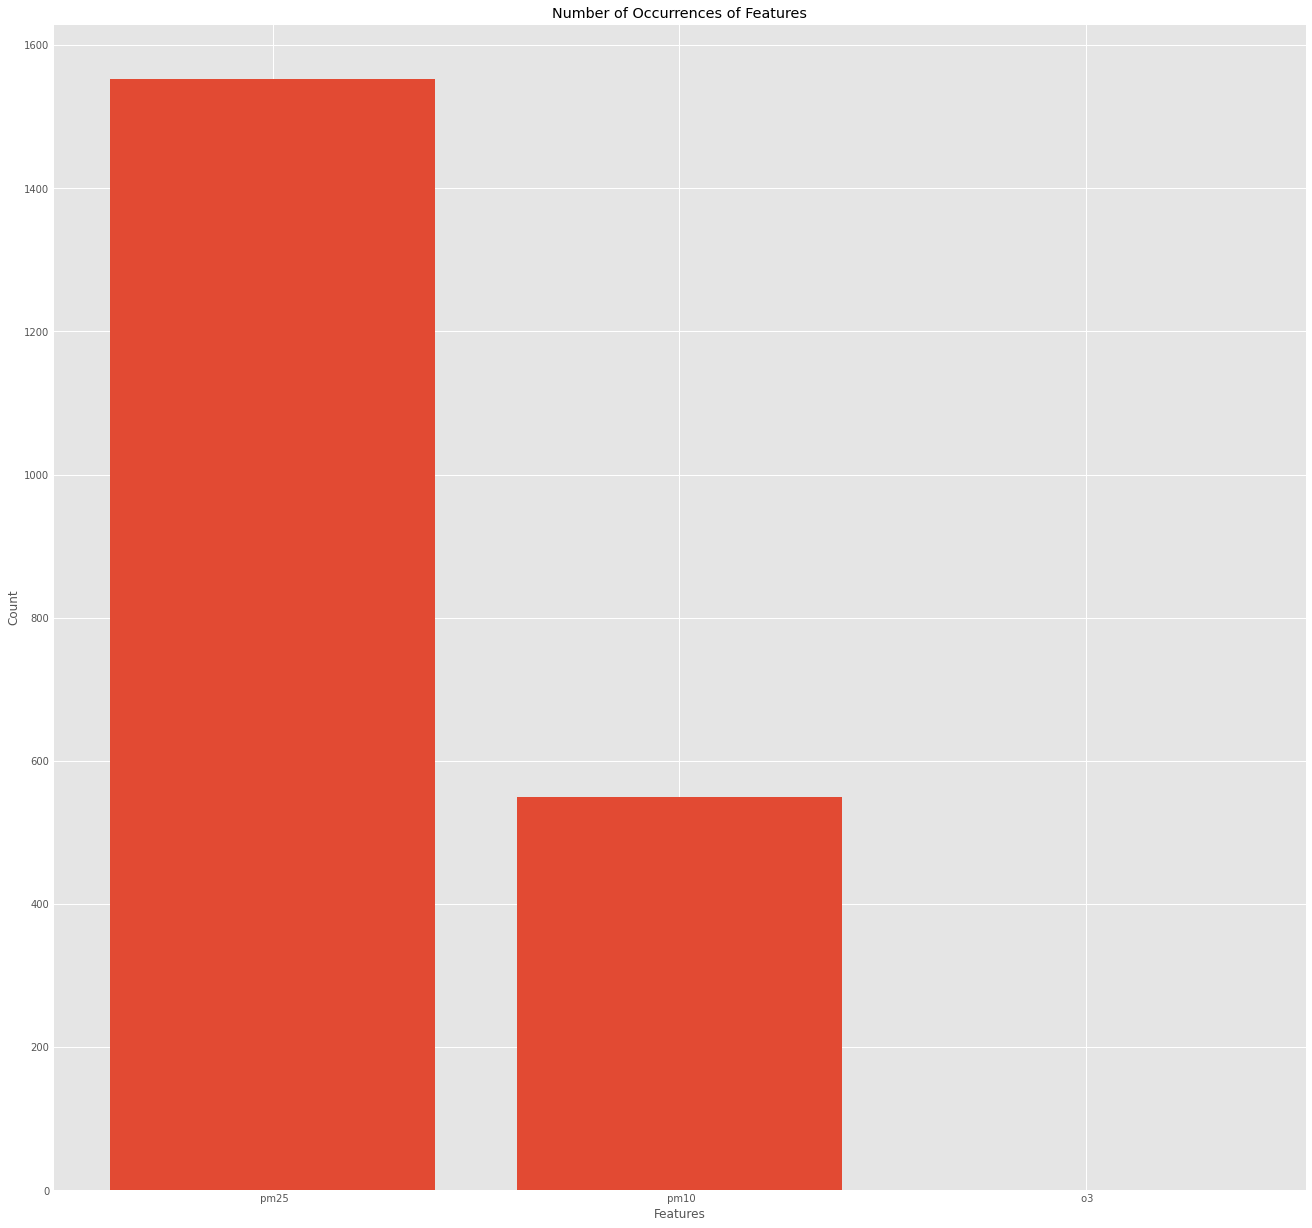

In [88]:

d = dict(zip(df['date'], df[columns_to_fill].idxmax(axis=1)))
feature_count = {}
for value in d.values():
    feature_count[value] = feature_count.get(value, 0) + 1

# Plotting the bar graph
plt.bar(feature_count.keys(), feature_count.values())
plt.xlabel('Features')
plt.ylabel('Count')
plt.title('Number of Occurrences of Features')
plt.show()

df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day


In [89]:
df

date        pm25    pm10    o3   no2        so2       co  \
0    2023-10-01  149.000000  115.00   8.0  13.0   1.000000   8.0000   
1    2023-10-02  142.000000  132.00   6.0  16.0   1.000000  10.0000   
2    2023-10-03  139.000000  149.00   8.0  18.0   1.000000  11.0000   
3    2023-10-04  145.000000  143.00   7.0  17.0   1.000000  10.0000   
4    2023-10-05  159.000000  137.00   5.0  17.0   1.000000  10.0000   
...         ...         ...     ...   ...   ...        ...      ...   
2097 2018-06-02  149.678571   87.00  56.0  11.0  10.000000   7.0000   
2098 2017-12-31  180.200000  212.00  37.0  14.0   5.688589  11.5776   
2099 2017-11-06  209.210526  280.00  12.0   7.0   5.688589  11.5776   
2100 2017-11-13  209.210526  189.00  29.0  21.0   5.688589  11.5776   
2101 2020-05-10  118.833333   83.25  49.0  10.0   5.688589   6.0000   

             AQI  year  month  day  
0     149.000000  2023     10    1  
1     142.000000  2023     10    2  
2     149.000000  2023     10    3  
3     145.000000  2023     10    4  
4     159.000000  2023     10    5  
...          ...   ...    ...  ...  
2097  149.678571  2018      6    2  
2098  212.000000  2017     12   31  
2099  280.000000  2017     11    6  
2100  209.210526  2017     11   13  
2101  118.833333  2020      5   10  

[2102 rows x 11 columns]

In [90]:
num_cols = [var for var in df.columns if df[var].dtype in ['int64','float64']]
df[num_cols].describe().T


count         mean        std     min     25%          50%      75%  \
 pm25  2102.0   155.240556  73.111128    17.0   103.0   145.000000   189.00   
 pm10  2102.0   134.715850  85.122334     9.0    79.0   119.000000   166.00   
 o3    2102.0    19.945166  16.071656     1.0     9.0    15.000000    25.00   
 no2   2102.0    22.137984  12.305760     1.0    12.0    21.000000    31.00   
 so2   2102.0     5.494444   3.520443     1.0     3.0     5.688589     7.00   
 co    2102.0    11.553582   6.357854     1.0     7.0    10.000000    14.00   
AQI    2102.0   166.490674  86.311022    17.0   109.0   151.000000   201.75   
year   2102.0  2020.367269   1.717074  2017.0  2019.0  2020.000000  2022.00   
month  2102.0     6.522835   3.478526     1.0     3.0     7.000000     9.00   
day    2102.0    15.691722   8.768595     1.0     8.0    16.000000    23.00   

          max  
 pm25   591.0  
 pm10   929.0  
 o3     135.0  
 no2     89.0  
 so2     23.0  
 co      94.0  
AQI     929.0  
year   2023.0  
month    12.0  
day      31.0

In [91]:
df1 = df.copy()


In [92]:
from scipy import stats
from pandas.plotting import autocorrelation_plot


def plot_num(data, var):
    plt.rcParams['figure.figsize']=(20,15)
    plt.suptitle('Air Pollution Exploratory Data Analysis',fontsize=25)
    plt.subplot(2,2,1)
    x=data[var]
    plt.hist(x,color='green',edgecolor='black')
    plt.title('{} histogram'.format(var))
    plt.xticks(rotation=45)
    
    
    plt.subplot(2,2,2)
    x=data[var]
    sns.boxplot(x, color="orange")
    plt.title('{} boxplot'.format(var))
    plt.xticks(rotation=45)
    
    
    plt.subplot(2,2,3)
    res = stats.probplot(data[var], plot=plt)
    plt.title('{} Q-Q plot'.format(var))
    plt.xticks(rotation=45)
    
    plt.subplot(2,2,4)
    # autocorrelation plot 
    autocorrelation_plot(df[var])
    plt.title("{} vs time autocorrelation".format(var)) 
    
    plt.show()


In [93]:
def barplot(data, var):
    plt.rcParams['figure.figsize']=(20,10)
    df= data.groupby(data[var])['AQI'].mean()
    df.plot.bar(color='blue')
    plt.suptitle('Distribution AQI per {}'.format(var),fontsize=25)
    plt.xlabel('{}'.format(var), fontsize=20)
    plt.ylabel('AQI', fontsize=20)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45, fontsize=20)
    plt.show()


In [94]:
def barplot2(data, var):
    plt.rcParams['figure.figsize']=(20,10)
    df= data.groupby(data[var])['AQI'].count()
    df.plot.bar(color='blue')
    plt.suptitle('Distribution AQI observations per {}'.format(var),fontsize=25)
    plt.xlabel('{}'.format(var), fontsize=15)
    plt.ylabel('count AQI', fontsize=15)
    plt.yticks(rotation=0, fontsize=15)
    plt.xticks(rotation=45, fontsize=15)
    plt.show()


In [95]:
def lineplot(data,var):
    plt.rcParams['figure.figsize']=(20,10)
    df= data.groupby(data[var])['AQI'].mean()
    df.plot(color='blue', linewidth=5)
    plt.suptitle('Distribution AQI per {}'.format(var),fontsize=25)
    plt.xlabel('{}'.format(var), fontsize=20)
    plt.ylabel('AQI', fontsize=20)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45, fontsize=20)
    plt.show() 


In [96]:
def tsplot(data,var,period):
    plt.rcParams['figure.figsize']=(20,10)
    if period=='all':
        plt.plot(data[var], linewidth=3, color='Orange')
    else:
        plt.plot(data[var].loc[period], linewidth=3,color='Orange') 
    plt.suptitle('Air Pollution Time Series',fontsize=25)
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('{}'.format(var), fontsize=20)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45, fontsize=20)
    plt.show()

In [97]:
def tsmultiplot(data,period):
    plt.rcParams['figure.figsize']=(20,10)
    if period=='all':
        plt.plot(data, linewidth=3)
    else:
        plt.plot(data.loc[period], linewidth=3) 
    my_labels=['AQI_Actual', 'AQI_Prediction']
    plt.suptitle('Air Pollution Time Series: Actual vs Prediction',fontsize=25)
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Actual vs Prediction',fontsize=20)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45, fontsize=20)
    plt.legend(my_labels,fontsize=20)
    plt.show()

In [98]:
# Evaluation function
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_validate


def evaluate(model, X, y, cv):
    def score_func(estimator, X, y):
        y_pred = estimator.predict(X)
        return {
            "root_mean_squared_error": np.sqrt(mean_squared_error(y, y_pred)),
            "mean_absolute_error": mean_absolute_error(y, y_pred),
        }
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=score_func,
        return_train_score=True
    )
    
    print('Train evaluation')
    for key, value in cv_results.items():
        if key.startswith("train_"):
            print(f"{key[6:]}: {value.mean():.3f} ± {value.std():.3f}")
 
    print('Test evaluation')
    for key, value in cv_results.items():
        if key.startswith("test_"):
            print(f"{key[5:]}: {value.mean():.3f} ± {value.std():.3f}")


In [99]:
print('\nMean :', np.mean(df1['AQI']),  
        '\nVariance :', np.var(df1['AQI']),
        '\nStandard Deviation :', np.var(df1['AQI']**0.5), 
        '\nSkewness :', stats.skew(df1['AQI']), 
        '\nKurtosis :', stats.kurtosis(df1['AQI']))



Mean : 166.49067374678071 
Variance : 7446.048389046377 
Standard Deviation : 9.45274385078514 
Skewness : 1.9743389408356495 
Kurtosis : 7.928386774769075


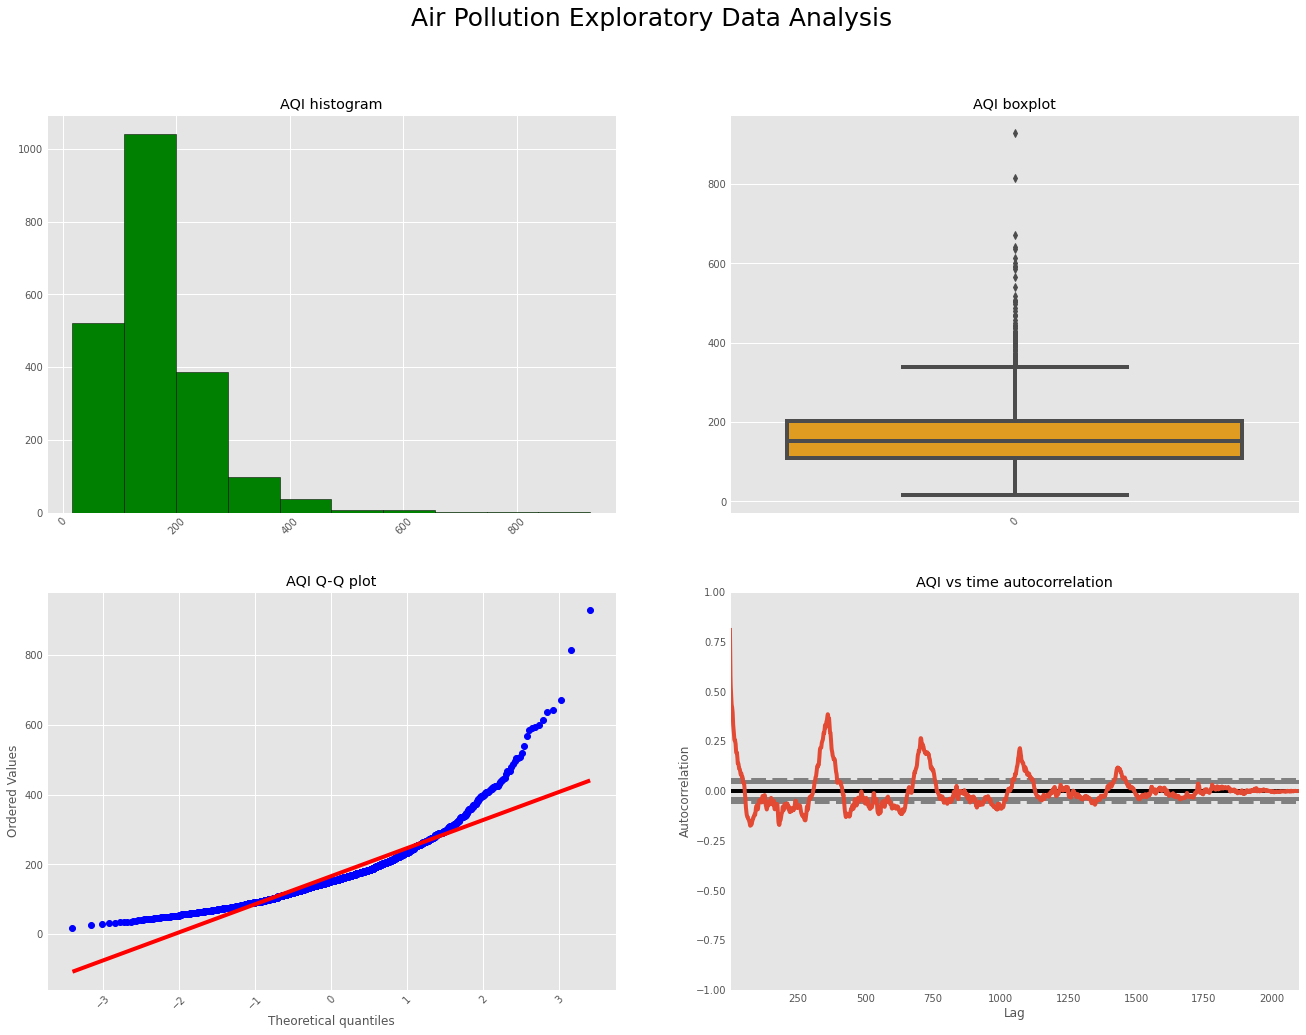

In [100]:
plot_num(df1, var='AQI')


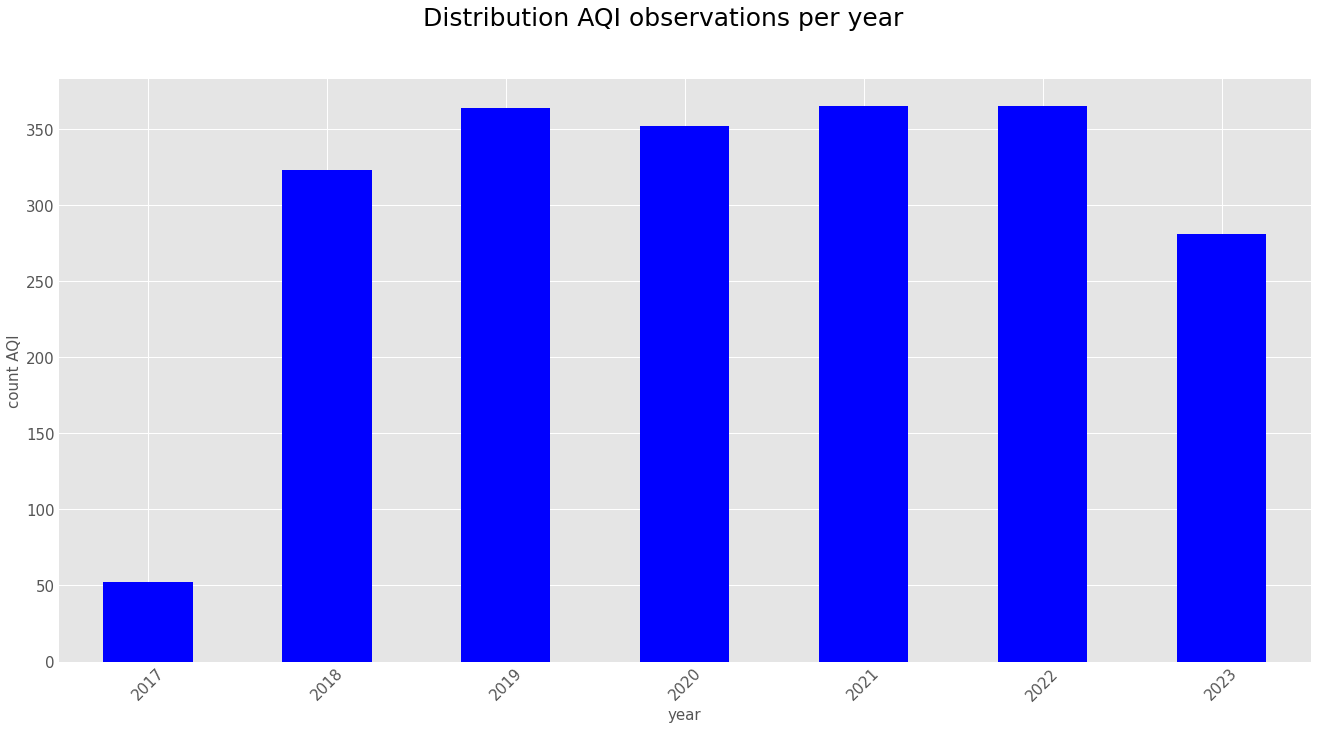

In [101]:
barplot2(df1,'year')


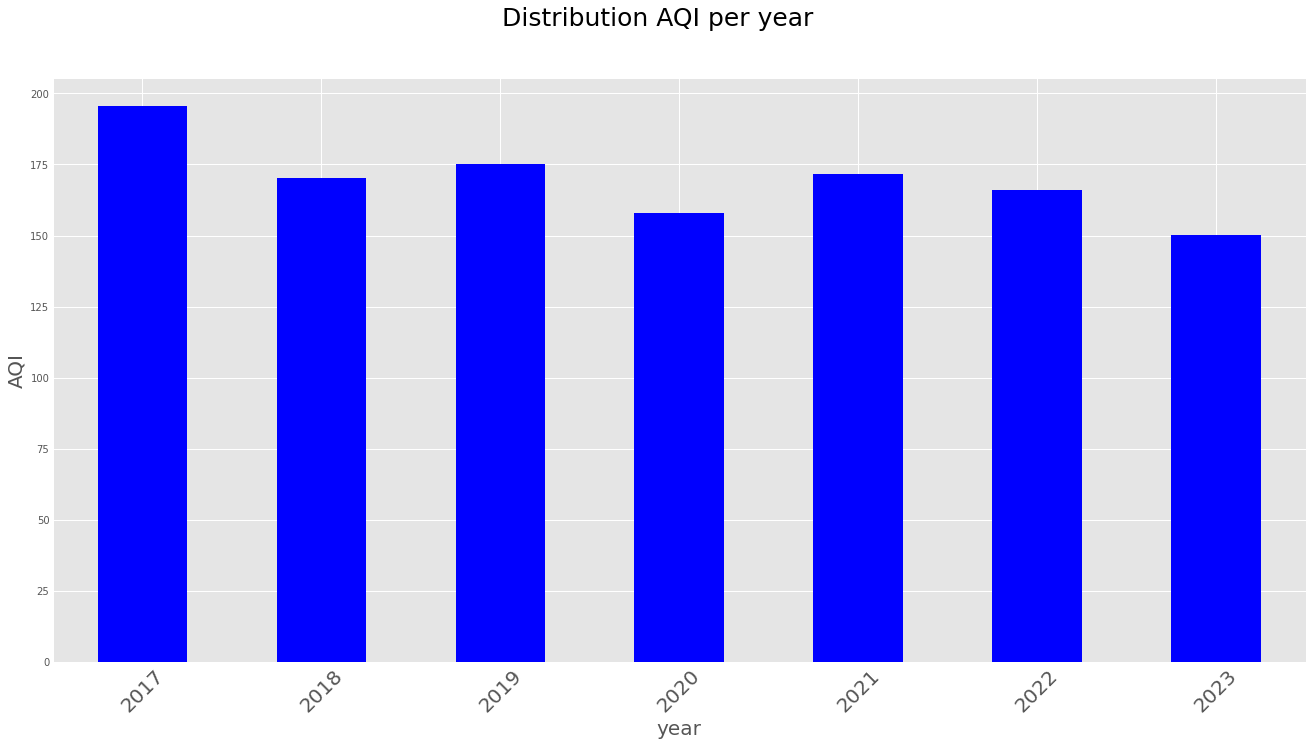

In [102]:
barplot(df1, var='year')


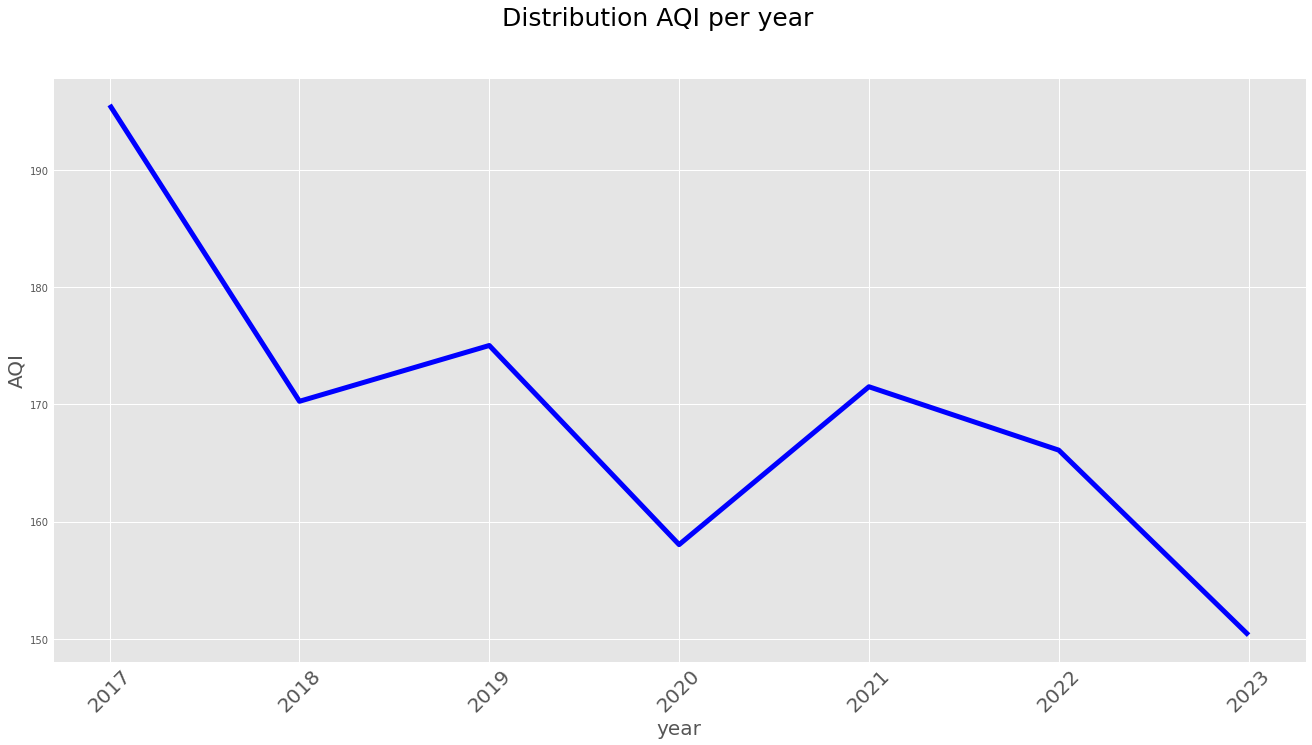

In [103]:
lineplot(df1,'year')


In [104]:
df1.groupby(df1['year'])['AQI'].mean()


year
2017    195.523279
2018    170.260044
2019    175.017052
2020    158.042252
2021    171.500551
2022    166.096895
2023    150.327558
Name: AQI, dtype: float64

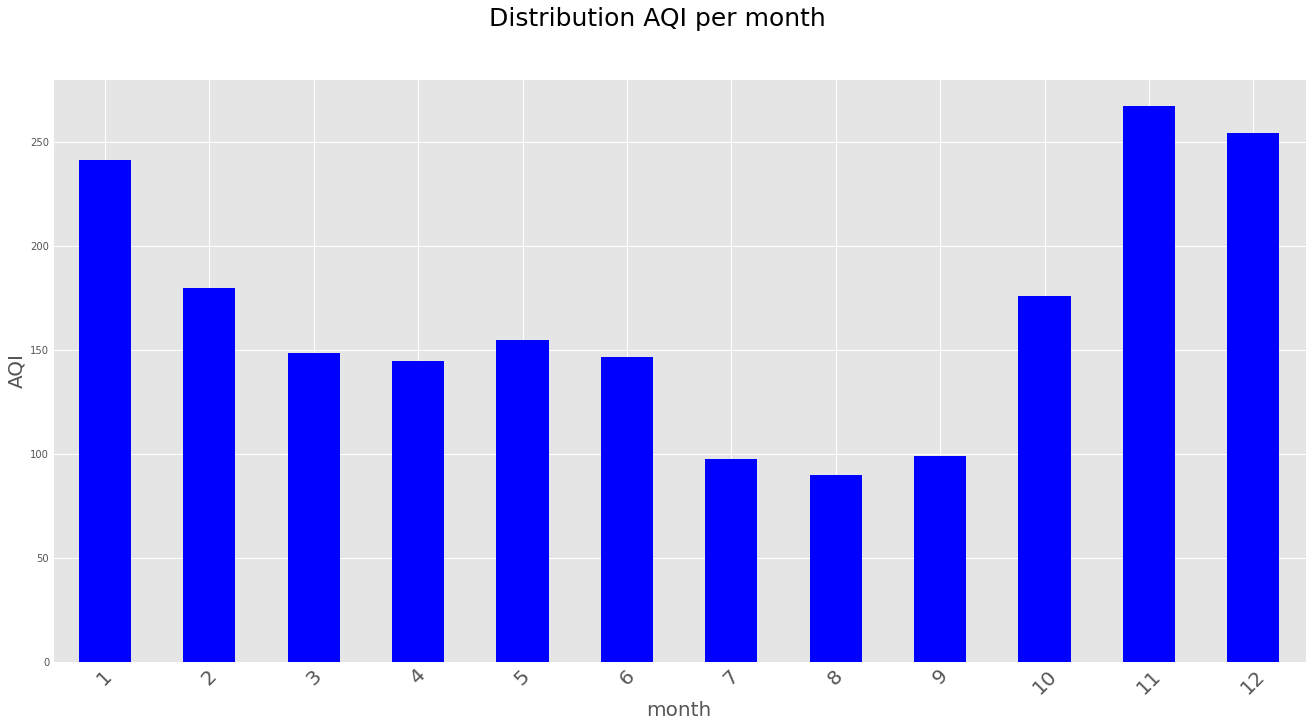

In [105]:
barplot(df1, var='month')


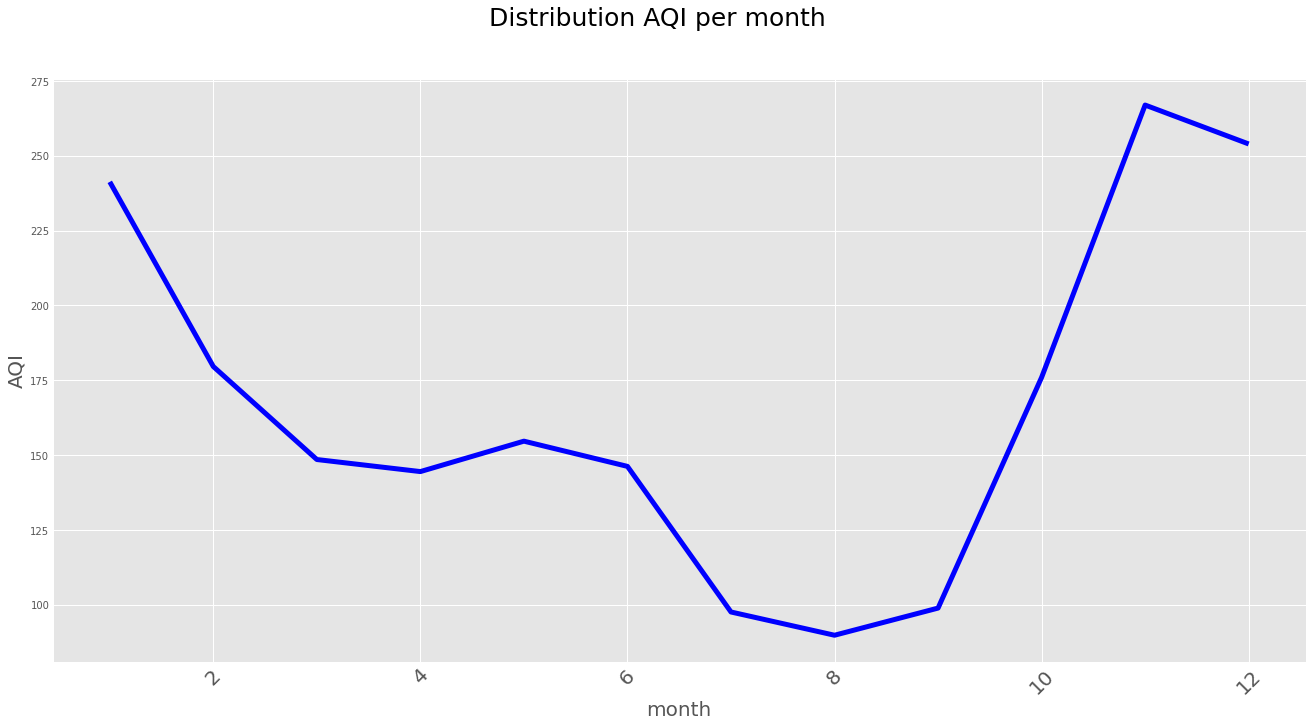

In [106]:
lineplot(df1,'month')


In [107]:
df1.groupby(df1['month'])['AQI'].mean()


month
1     241.284946
2     179.605961
3     148.537807
4     144.511666
5     154.672185
6     146.244014
7      97.609091
8      89.844086
9      98.913793
10    175.972584
11    266.942953
12    253.947064
Name: AQI, dtype: float64

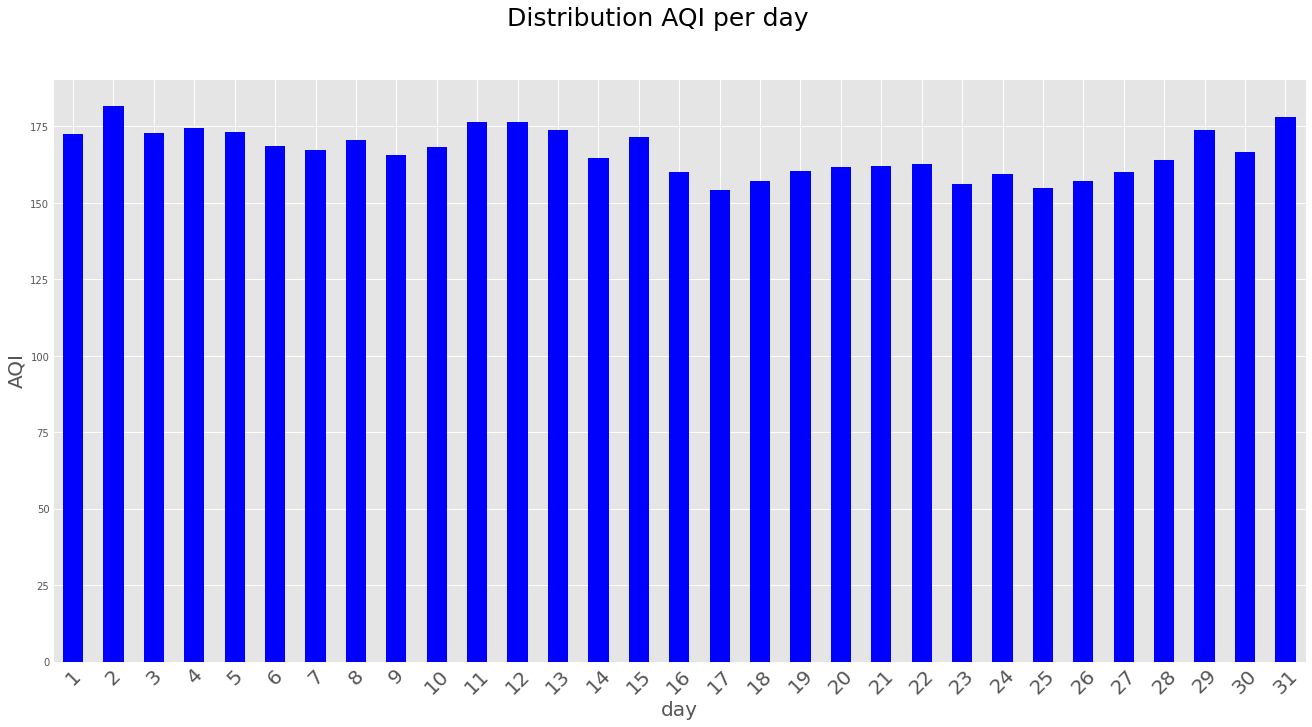

In [108]:
barplot(df1, var='day')


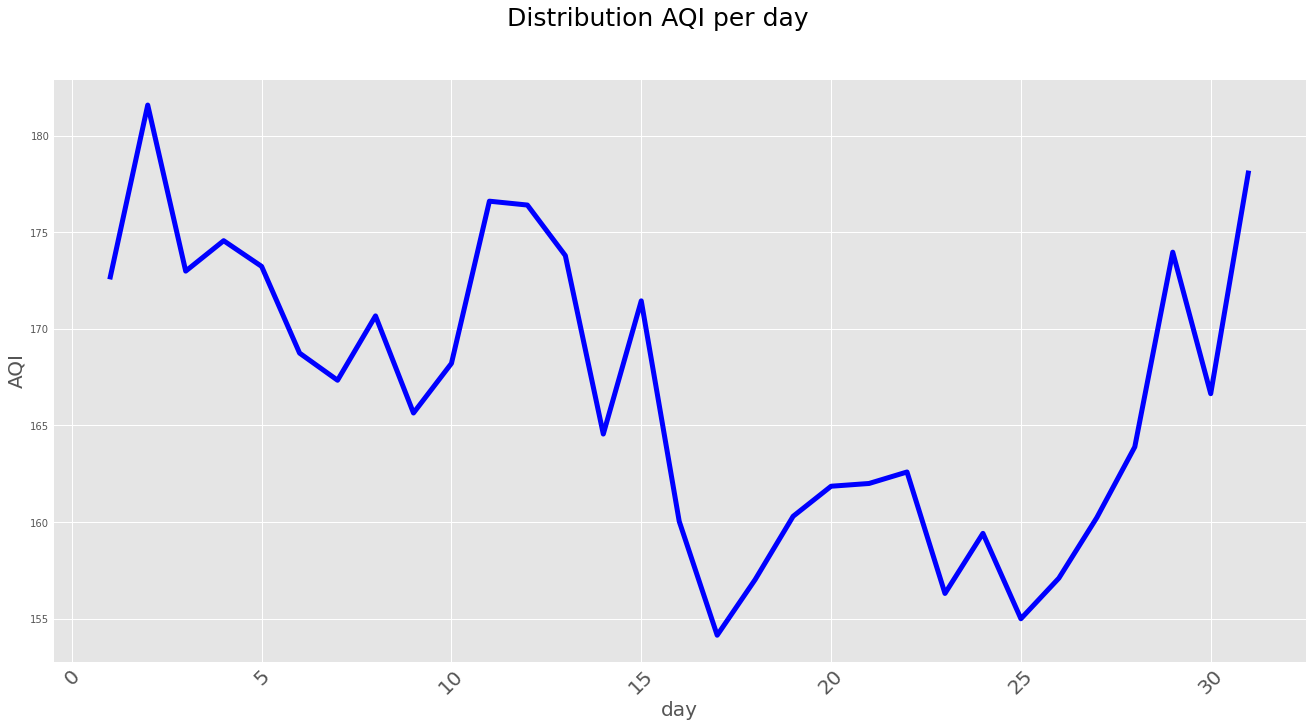

In [109]:
lineplot(df1,'day')


In [110]:
df1.groupby(df1['day'])['AQI'].mean()


day
1     172.559331
2     181.575902
3     172.985294
4     174.558824
5     173.229469
6     168.743838
7     167.339906
8     170.669099
9     165.645455
10    168.211905
11    176.602941
12    176.403382
13    173.789057
14    164.557143
15    171.446777
16    160.040761
17    154.149504
18    157.028986
19    160.301630
20    161.857143
21    162.000000
22    162.594203
23    156.310252
24    159.420290
25    155.002635
26    157.101449
27    160.235294
28    163.892157
29    173.965820
30    166.645161
31    178.184792
Name: AQI, dtype: float64

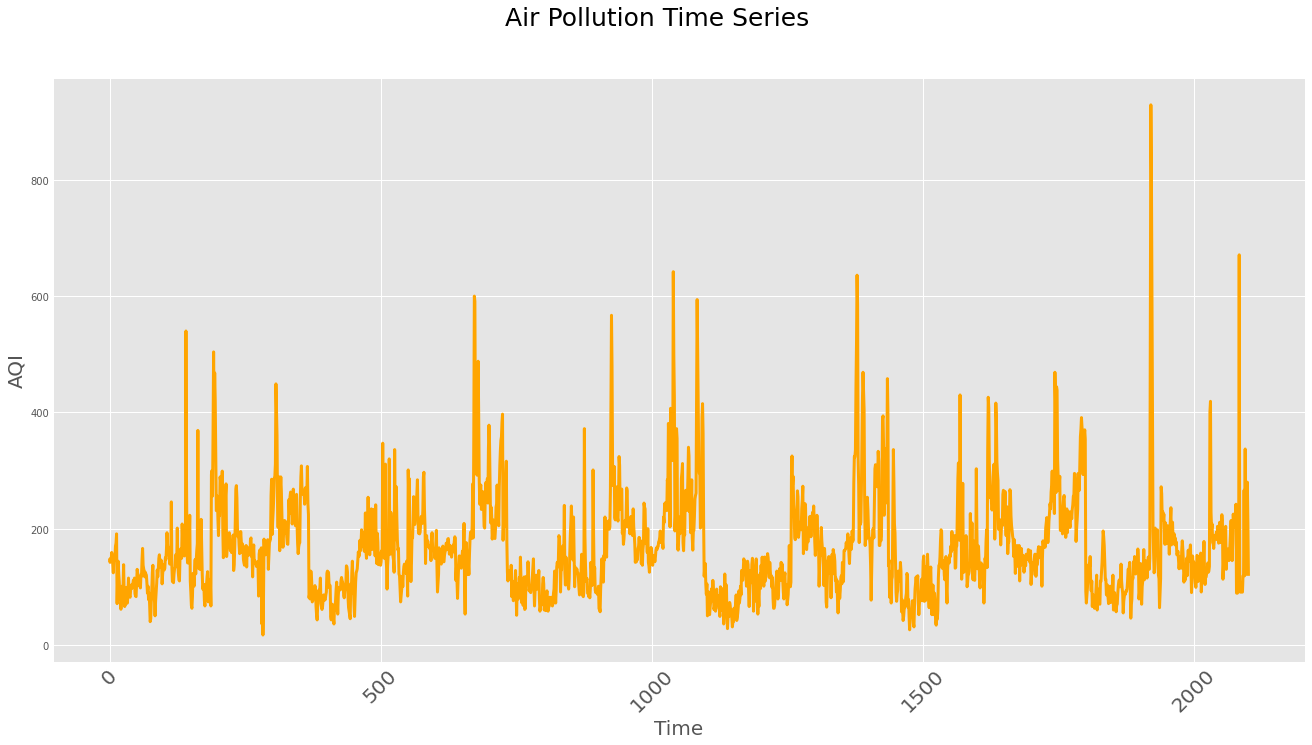

In [111]:
# Look at the whole Air Pollution time series
tsplot(df1, var='AQI', period='all')


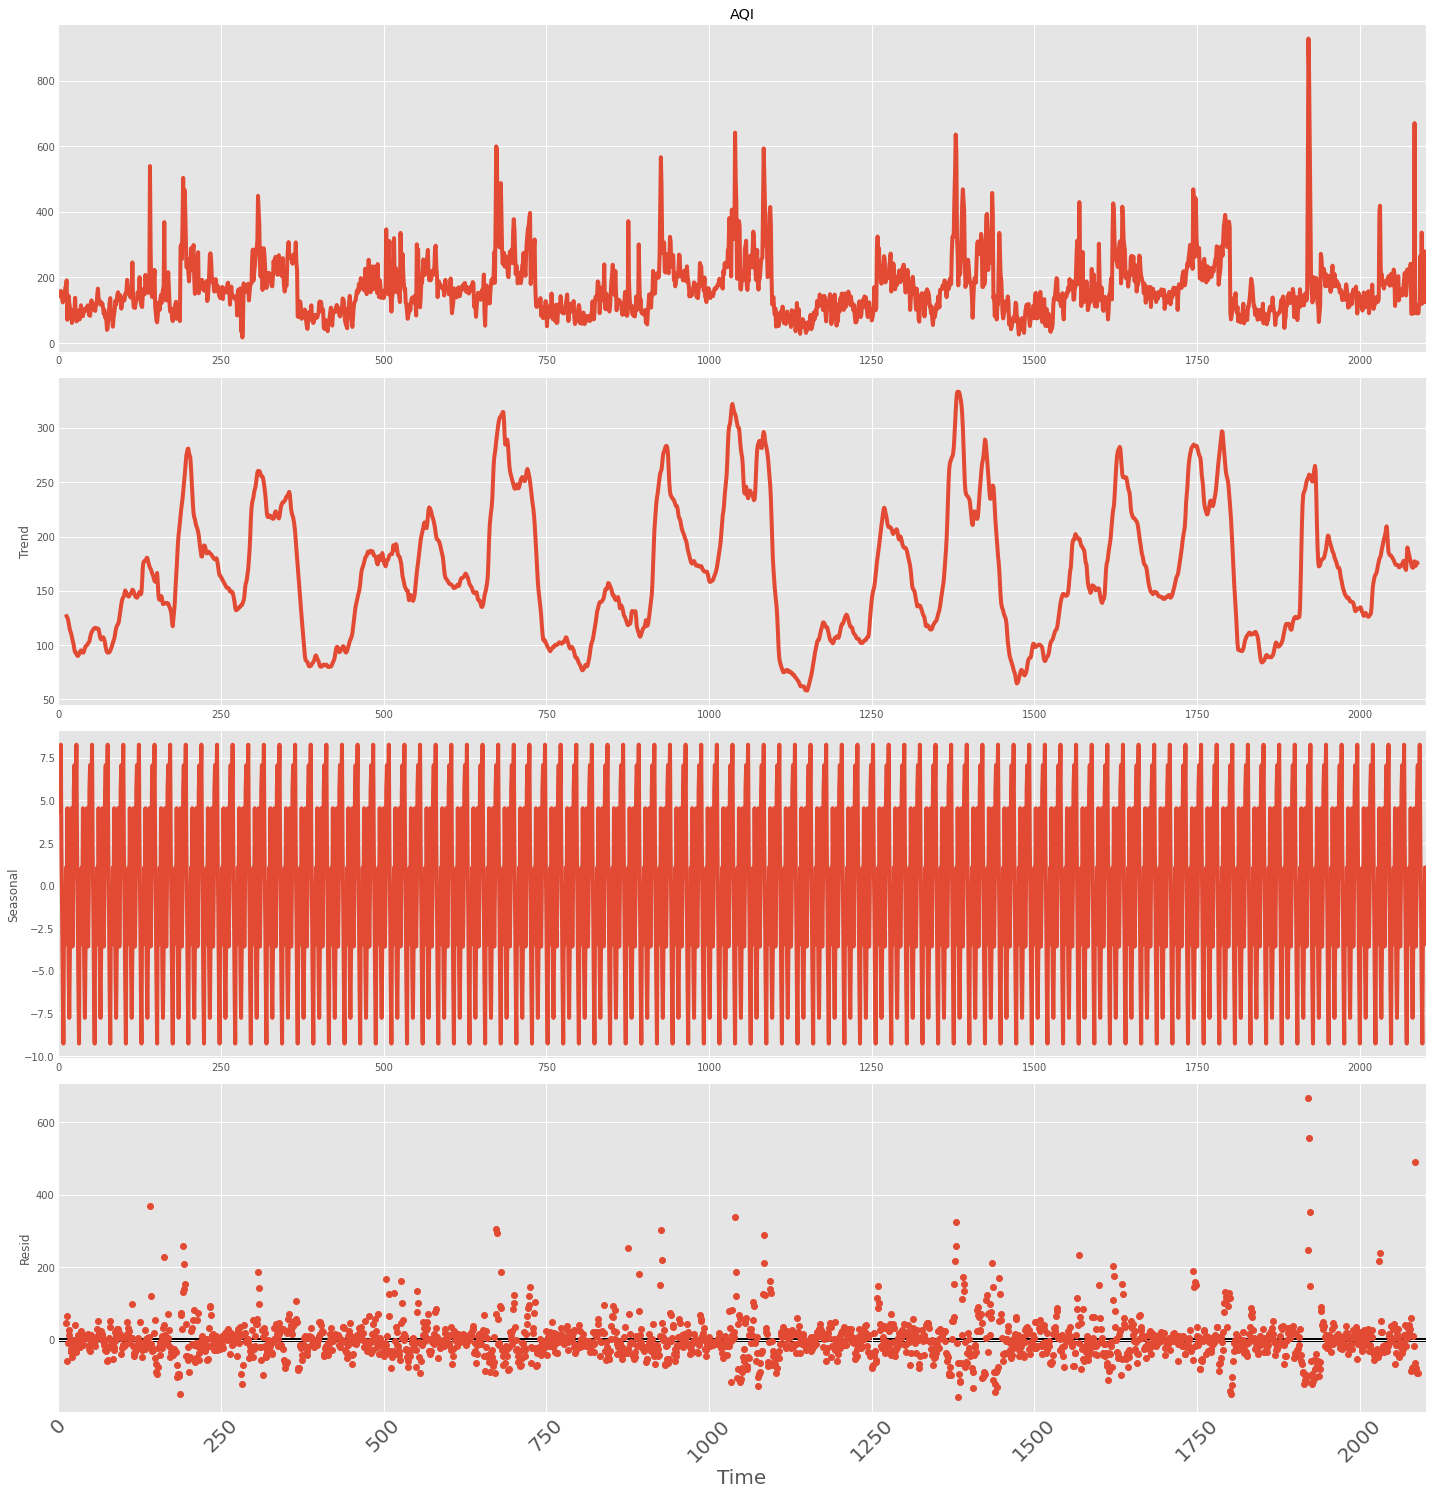

In [112]:
from statsmodels.tsa.seasonal import seasonal_decompose

add_res = seasonal_decompose(x=df1['AQI'], model="additive", period=24)
plt.rcParams['figure.figsize']=(20,20)
add_res.plot()
plt.xlabel('Time', fontsize=20)
plt.yticks(rotation=0)
plt.xticks(rotation=45, fontsize=20)
plt.show()

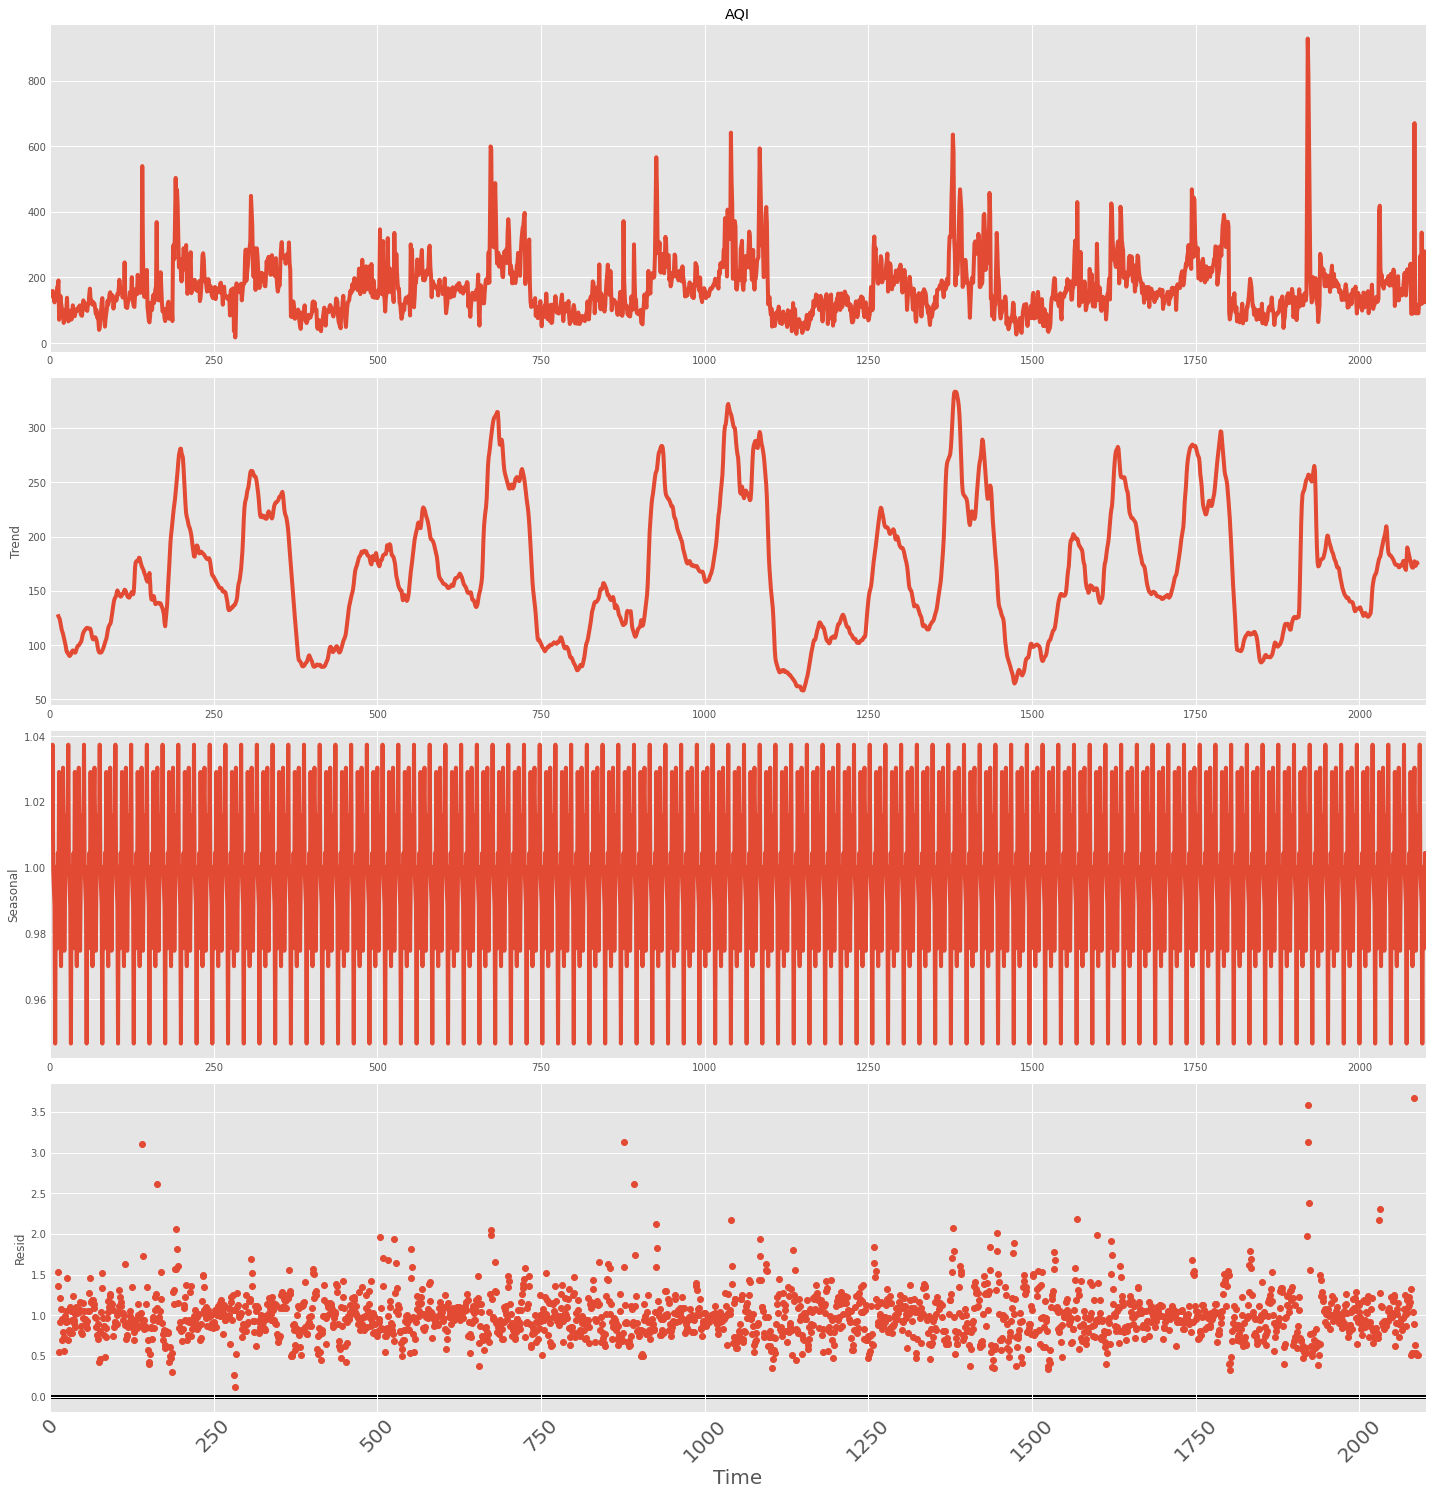

In [113]:
# Multiplicative Decomposition
mul_res = seasonal_decompose(x=df1['AQI'], model="multiplicative", period=24)
plt.rcParams['figure.figsize']=(20,20)
mul_res.plot()
plt.xlabel('Time', fontsize=20)
plt.yticks(rotation=0)
plt.xticks(rotation=45, fontsize=20)
plt.show()

In [114]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2102 entries, 0 to 2101
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2102 non-null   datetime64[ns]
 1    pm25   2102 non-null   float64       
 2    pm10   2102 non-null   float64       
 3    o3     2102 non-null   float64       
 4    no2    2102 non-null   float64       
 5    so2    2102 non-null   float64       
 6    co     2102 non-null   float64       
 7   AQI     2102 non-null   float64       
 8   year    2102 non-null   int64         
 9   month   2102 non-null   int64         
 10  day     2102 non-null   int64         
dtypes: datetime64[ns](1), float64(7), int64(3)
memory usage: 261.6 KB


In [115]:
#  statistics of partitioned time series 
X = df1['AQI'].values
split = int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=166.743204, mean2=166.238144
variance1=6342.497049, variance2=8549.472186


In [116]:
#  statistics of log partitioned time series
X = df1['AQI'].values
X = np.log1p(X)
split = int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=5.020407, mean2=4.990285
variance1=0.206616, variance2=0.258464


In [117]:
# Augmented Dickey-Fuller test
X = df1['AQI'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.874270
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.568


In [118]:
df3 = df1.query('year>=2018 and year <=2022')


In [119]:
ts = df3['AQI'].copy() 
ts

276     156.000000
277     163.000000
278     131.000000
279     144.000000
280     167.000000
           ...    
2094    118.827586
2095    337.000000
2096    121.315789
2097    149.678571
2101    118.833333
Name: AQI, Length: 1769, dtype: float64

LSTM

In [120]:

import datetime

import math
from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm
plt.style.use("fivethirtyeight")
from keras.models import Sequential
from keras.layers import Dense, LSTM




In [121]:
df

date        pm25    pm10    o3   no2        so2       co  \
0    2023-10-01  149.000000  115.00   8.0  13.0   1.000000   8.0000   
1    2023-10-02  142.000000  132.00   6.0  16.0   1.000000  10.0000   
2    2023-10-03  139.000000  149.00   8.0  18.0   1.000000  11.0000   
3    2023-10-04  145.000000  143.00   7.0  17.0   1.000000  10.0000   
4    2023-10-05  159.000000  137.00   5.0  17.0   1.000000  10.0000   
...         ...         ...     ...   ...   ...        ...      ...   
2097 2018-06-02  149.678571   87.00  56.0  11.0  10.000000   7.0000   
2098 2017-12-31  180.200000  212.00  37.0  14.0   5.688589  11.5776   
2099 2017-11-06  209.210526  280.00  12.0   7.0   5.688589  11.5776   
2100 2017-11-13  209.210526  189.00  29.0  21.0   5.688589  11.5776   
2101 2020-05-10  118.833333   83.25  49.0  10.0   5.688589   6.0000   

             AQI  year  month  day  
0     149.000000  2023     10    1  
1     142.000000  2023     10    2  
2     149.000000  2023     10    3  
3     145.000000  2023     10    4  
4     159.000000  2023     10    5  
...          ...   ...    ...  ...  
2097  149.678571  2018      6    2  
2098  212.000000  2017     12   31  
2099  280.000000  2017     11    6  
2100  209.210526  2017     11   13  
2101  118.833333  2020      5   10  

[2102 rows x 11 columns]

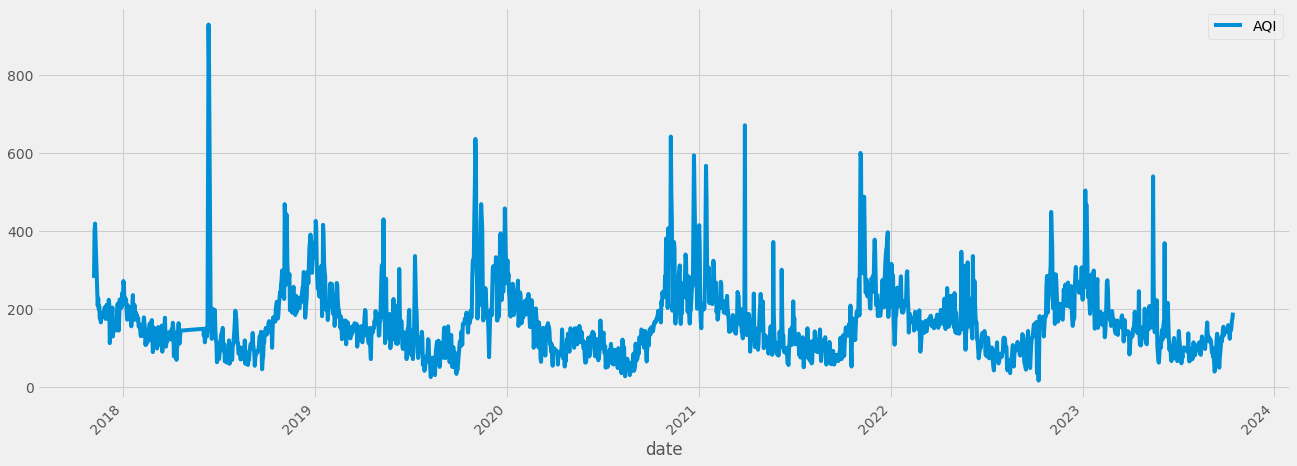

In [122]:
df.plot(x='date',y='AQI',figsize=(20,8))
plt.xticks(rotation=45)

plt.show()

<Axes: xlabel='year'>

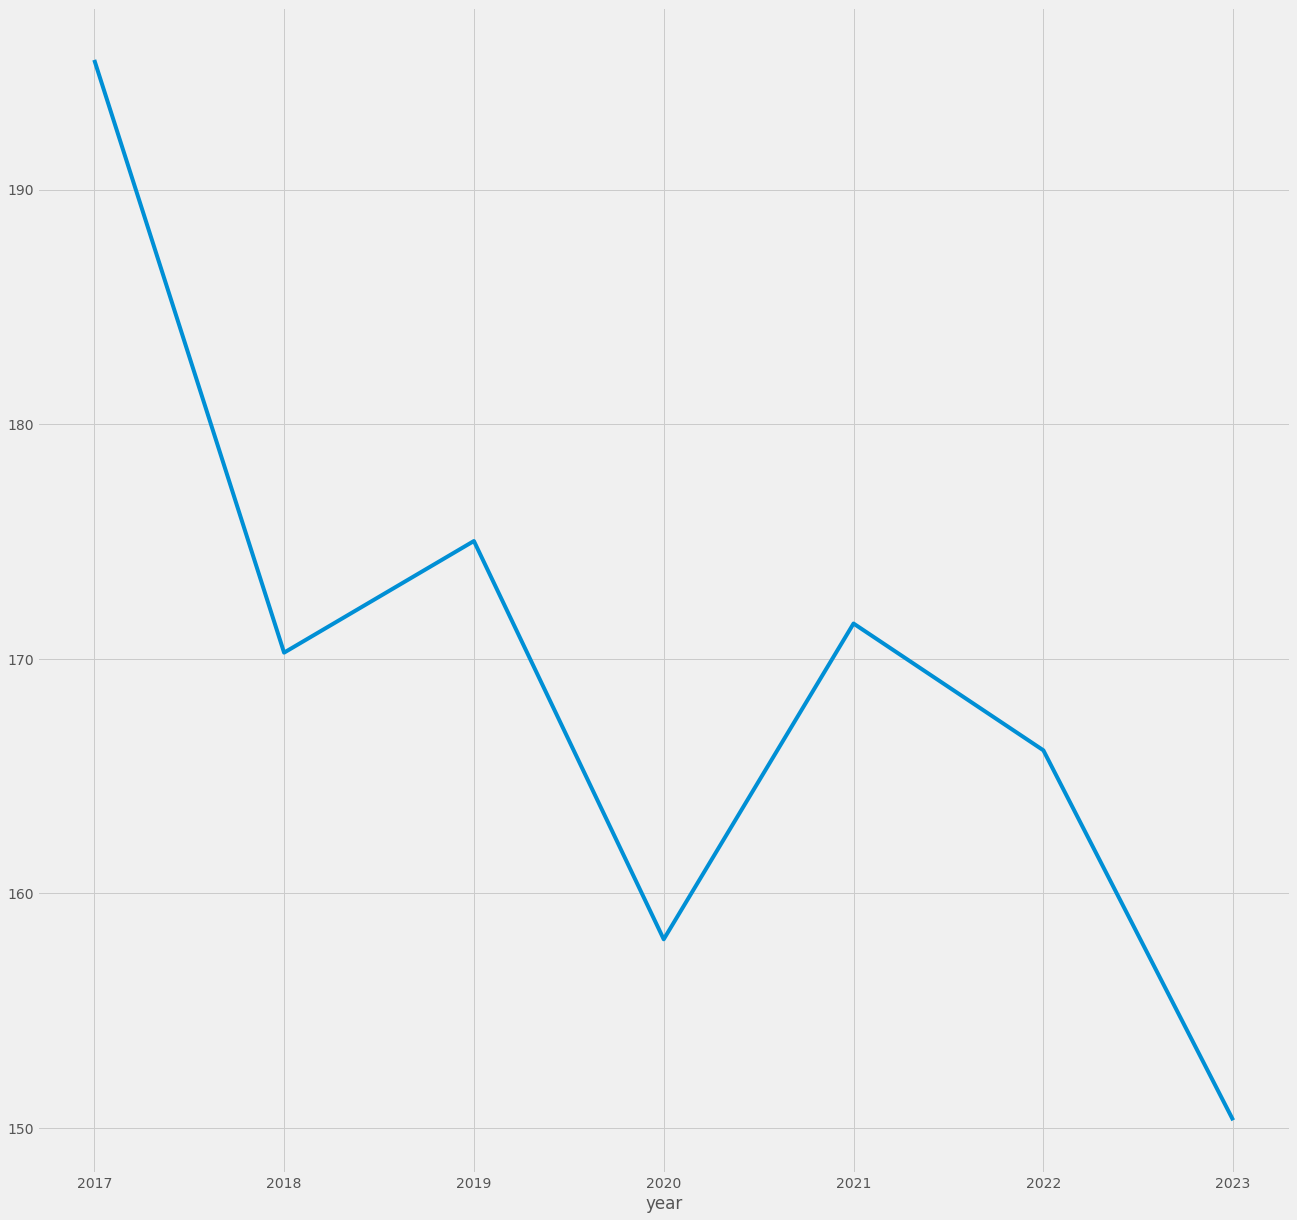

In [123]:
df.groupby('year')['AQI'].mean().plot()


<Axes: xlabel='year', ylabel='AQI'>

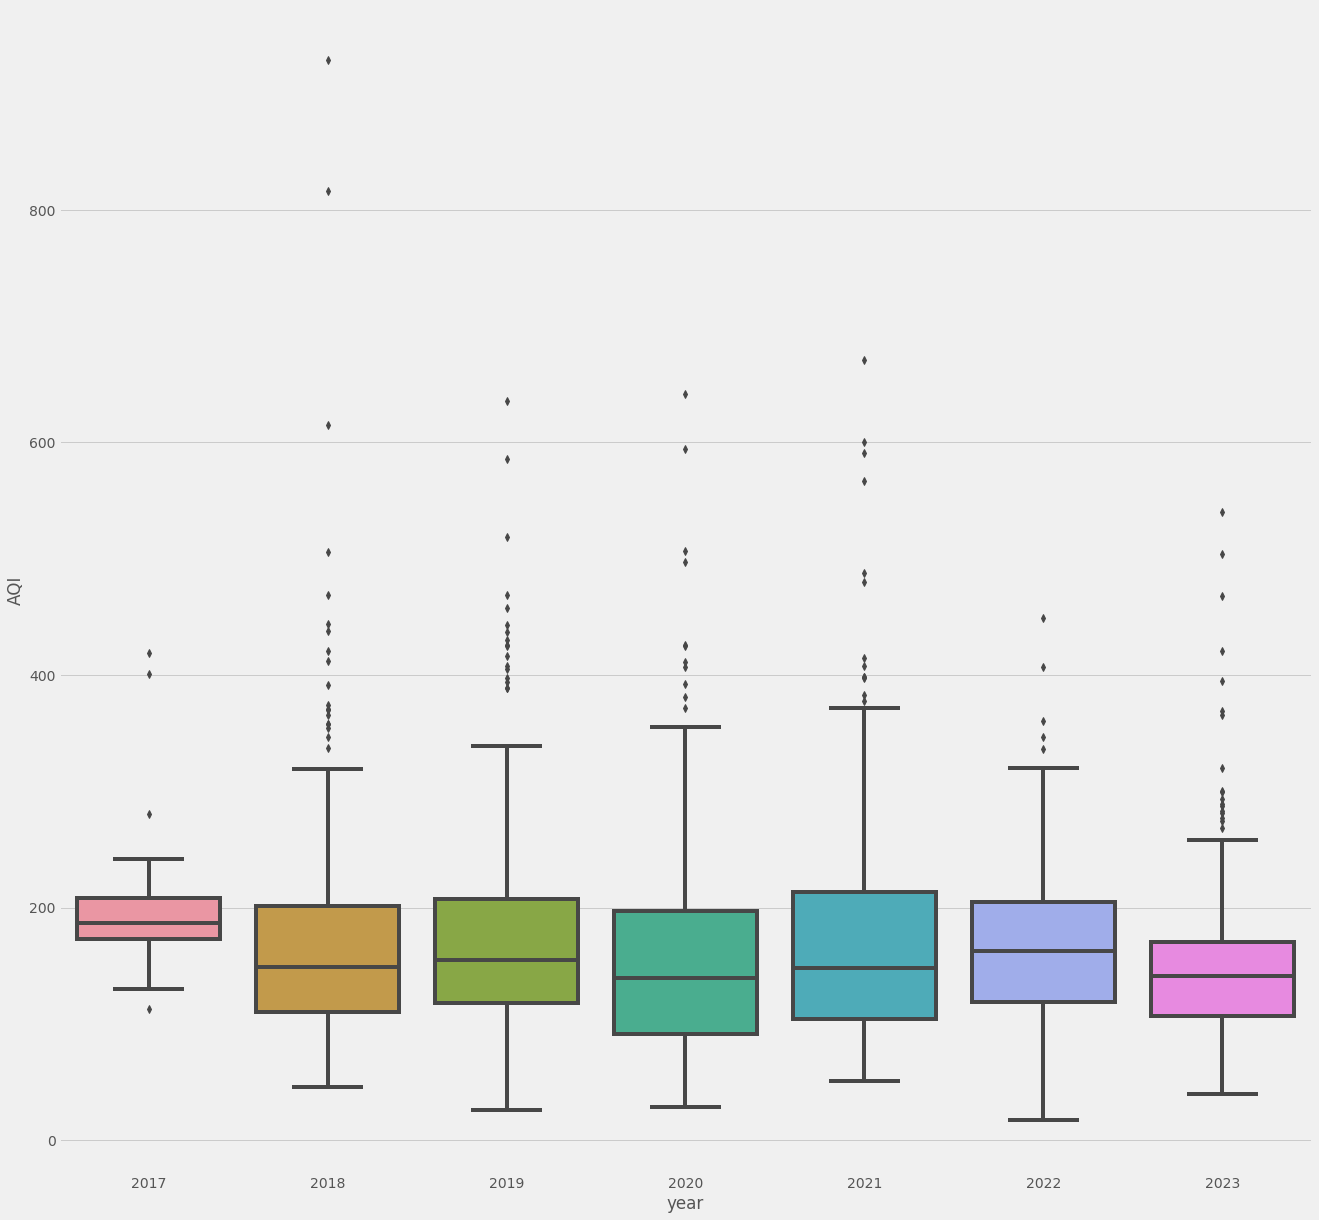

In [124]:
df_year=df.loc[:,['year','AQI']]
sns.boxplot(x='year', y='AQI',data=df_year)

<Axes: xlabel='month'>

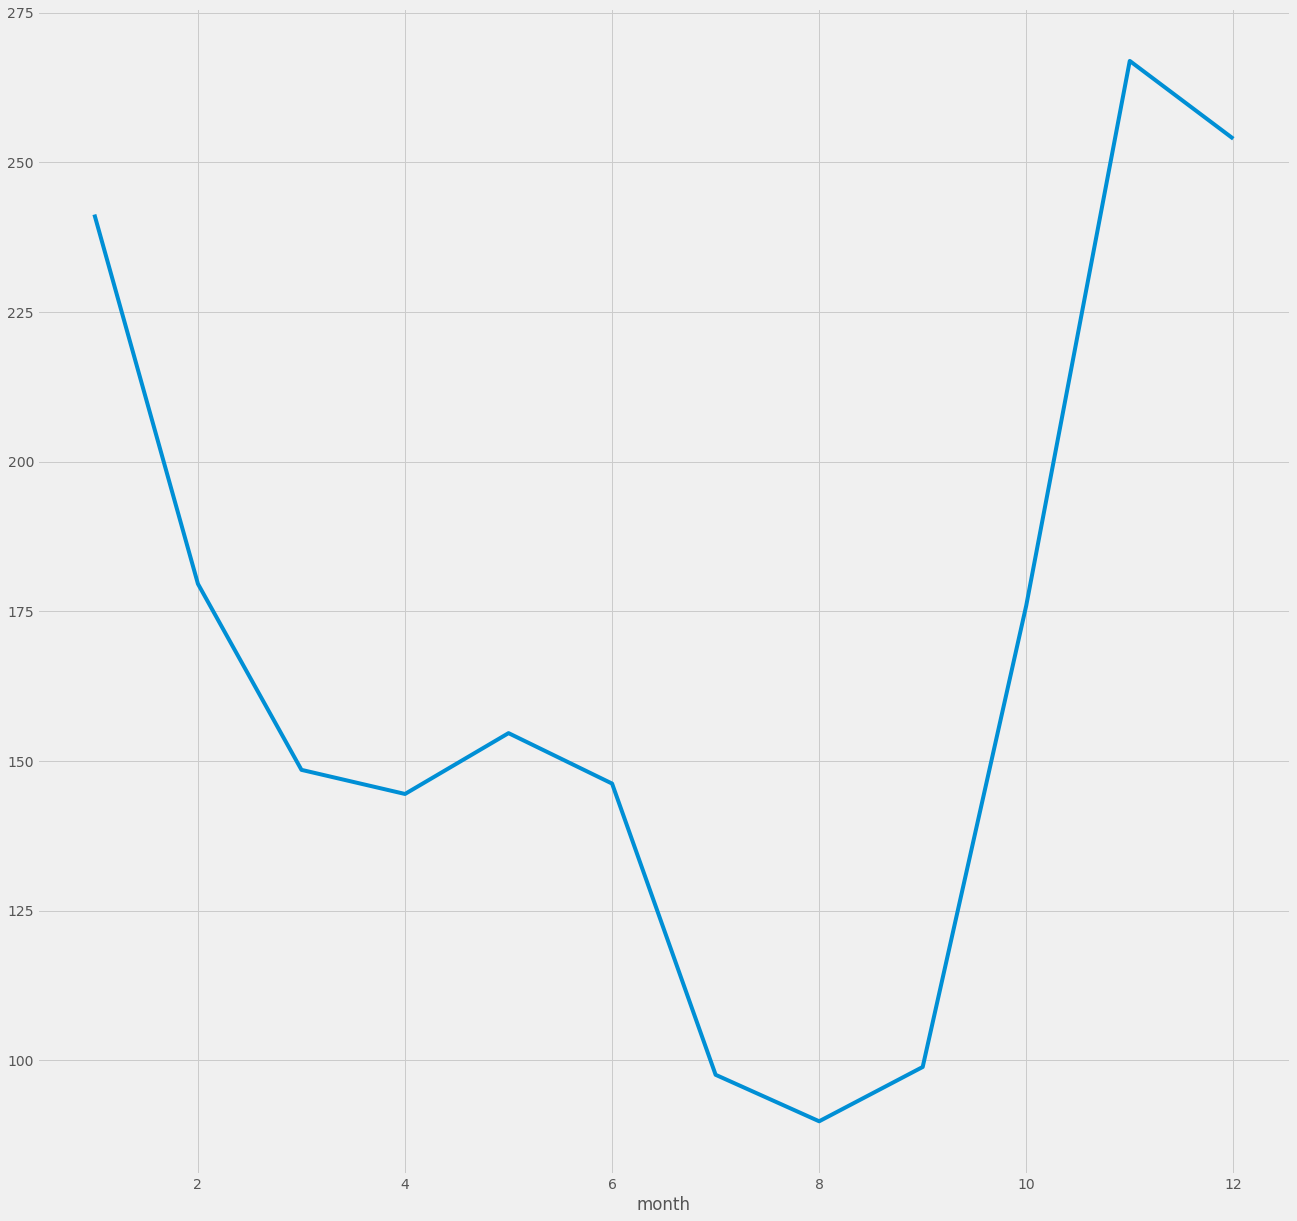

In [125]:
df.groupby('month')['AQI'].mean().plot()


<Axes: xlabel='month', ylabel='AQI'>

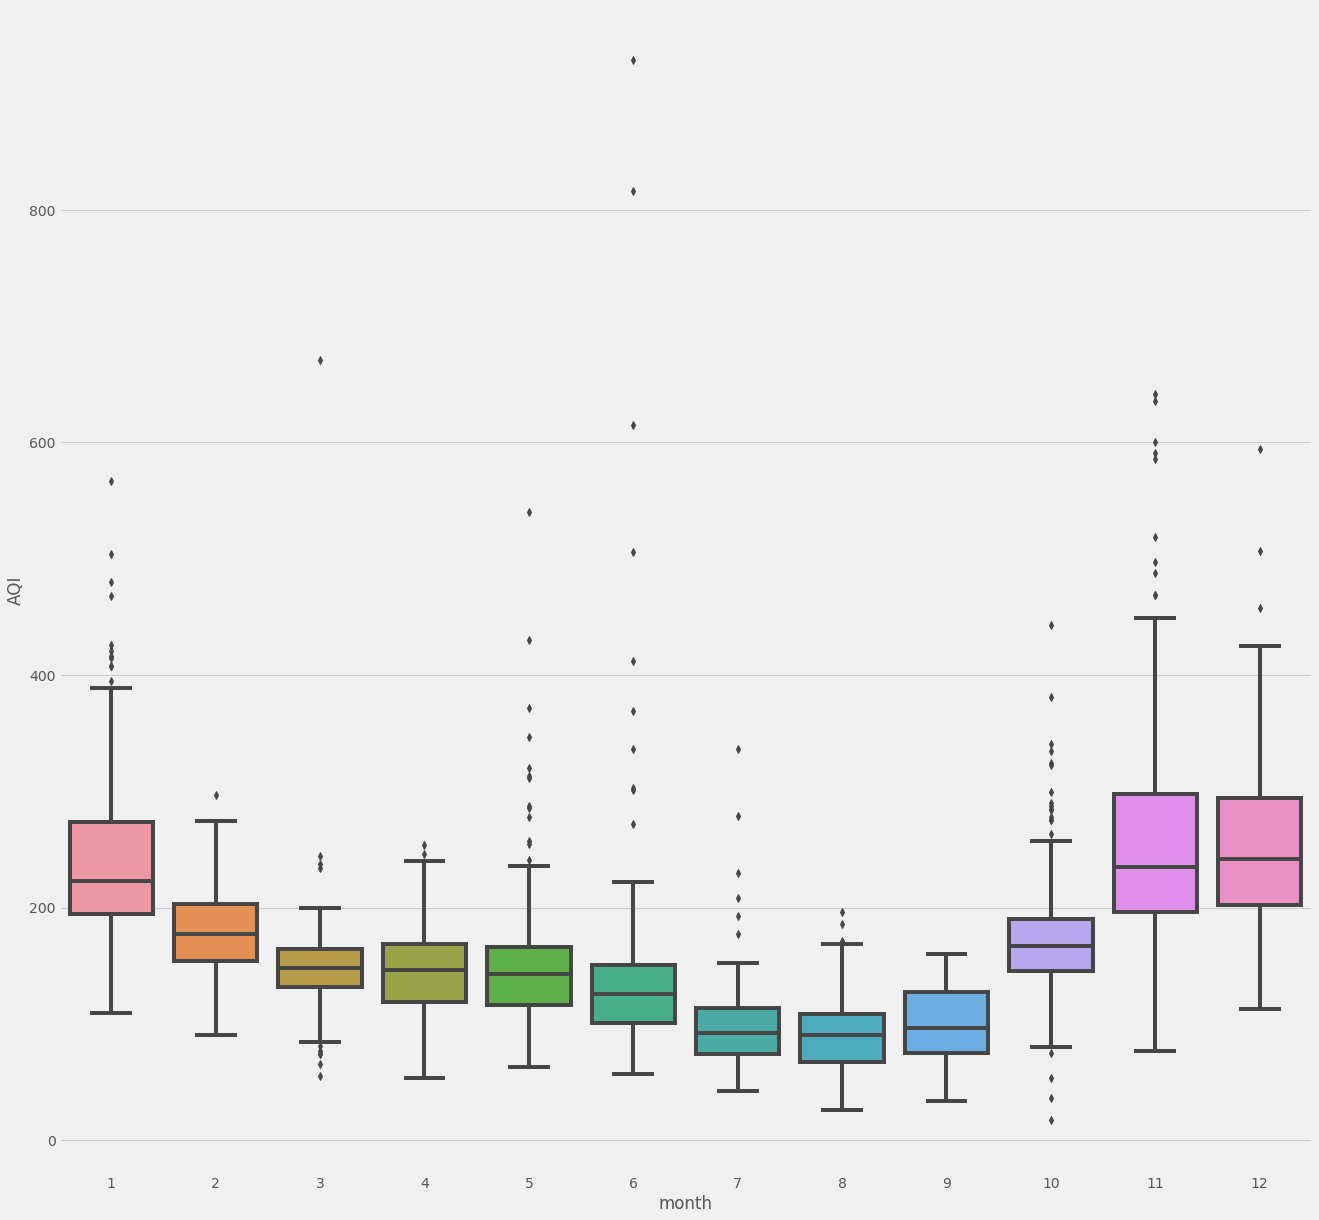

In [126]:
df_month=df.loc[:,['month','AQI']]
sns.boxplot(x='month', y='AQI',data=df_month)

<Axes: xlabel='day'>

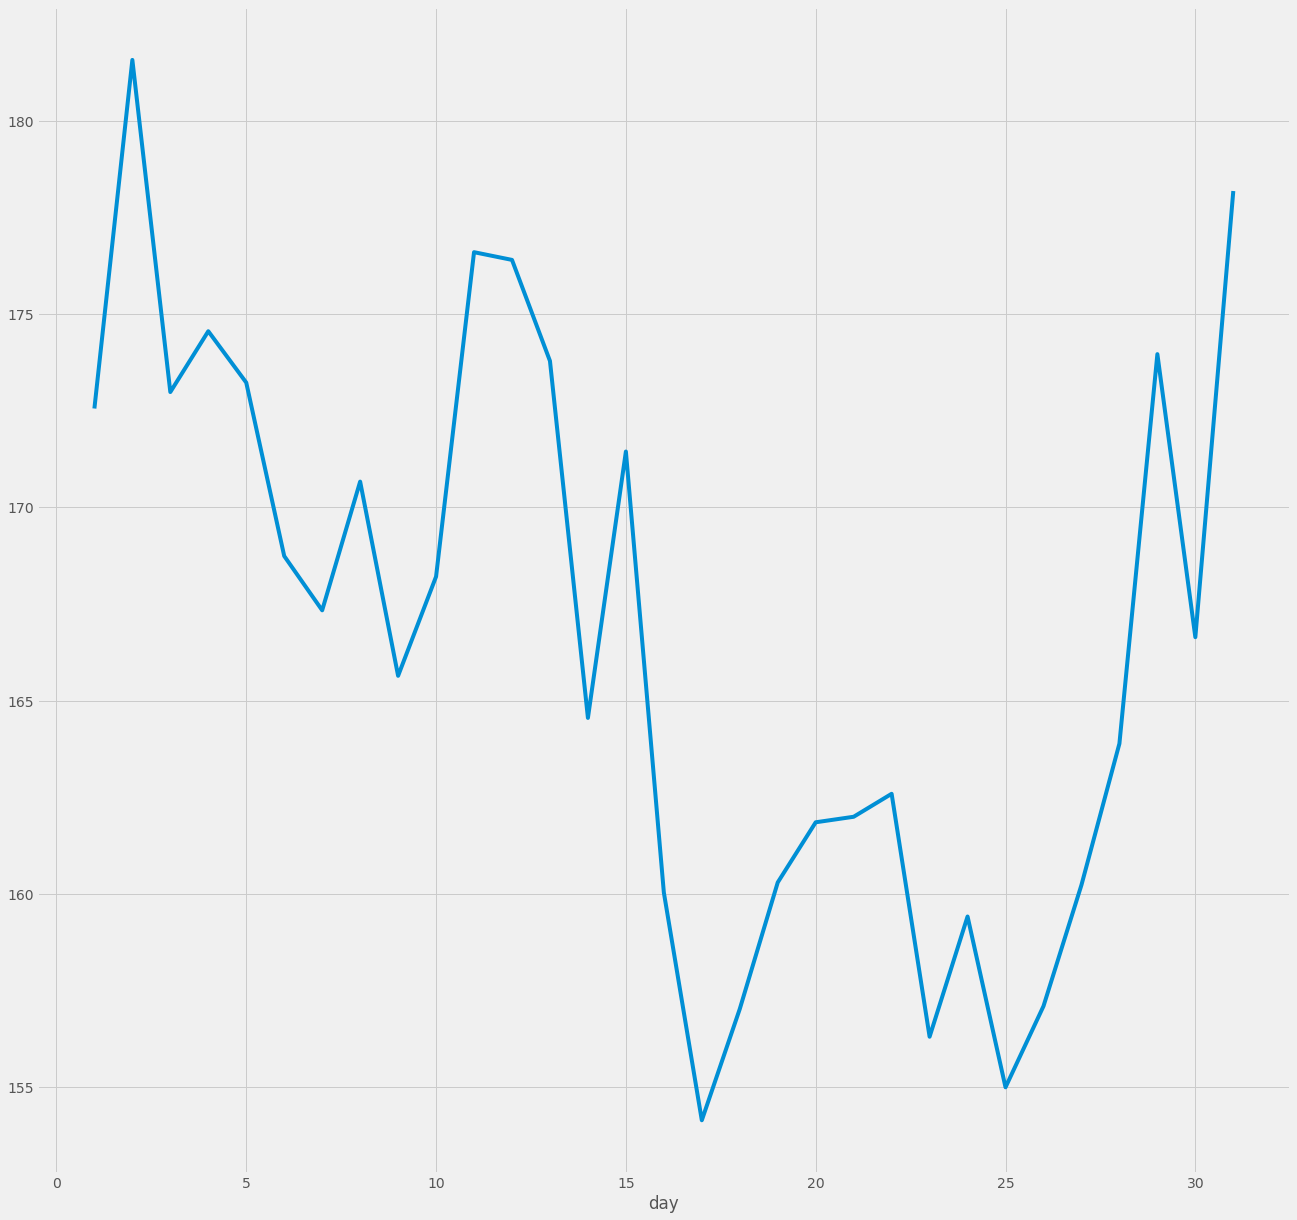

In [127]:
df.groupby('day')['AQI'].mean().plot()


<Axes: xlabel='day', ylabel='AQI'>

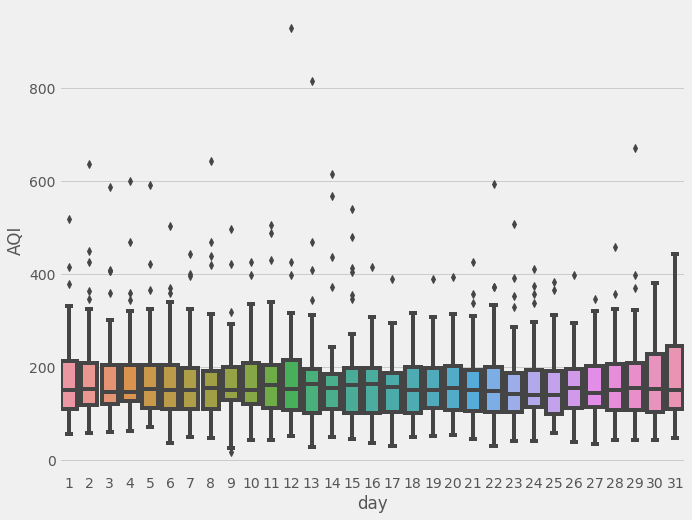

In [128]:
df_day=df.loc[:,['day','AQI']]
plt.figure(figsize=(10,8))
sns.boxplot(x='day', y='AQI',data=df_day)


In [129]:
df_date=pd.DataFrame(df.groupby('date')['AQI'].mean())
df_date


AQI
date                  
2017-11-06  280.000000
2017-11-07  401.000000
2017-11-08  419.000000
2017-11-13  209.210526
2017-11-14  228.000000
...                ...
2023-10-10  145.000000
2023-10-11  151.000000
2023-10-12  170.000000
2023-10-13  175.000000
2023-10-14  191.000000

[2102 rows x 1 columns]

<Axes: xlabel='date'>

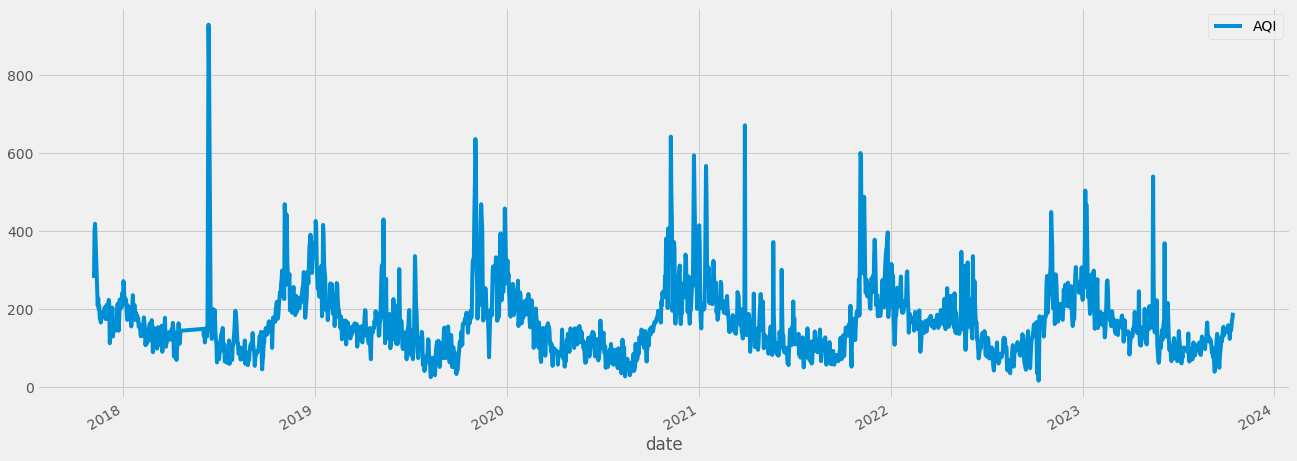

In [130]:
df_date.plot(figsize=(20,8))

In [131]:
dataset  = df_date.values
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

1682

In [132]:
sc = MinMaxScaler(feature_range=(0,1))
scaled_data = sc.fit_transform(dataset)
scaled_data

array([[0.28837719],
       [0.42105263],
       [0.44078947],
       ...,
       [0.16776316],
       [0.17324561],
       [0.19078947]])

In [133]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []
num = 60
for i in range(num, len(train_data)):
    x_train.append(train_data[i-num:i , 0])
    y_train.append(train_data[i , 0])

In [134]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1622, 60, 1)

In [135]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [136]:
model.compile(optimizer = "adam", loss = "mean_squared_error")


In [137]:
model.fit(x_train,y_train, batch_size=1, epochs=15)


Epoch 1/15
1622/1622 [==============================] - 14s 8ms/step - loss: 0.0050
Epoch 2/15
1622/1622 [==============================] - 13s 8ms/step - loss: 0.0033
Epoch 3/15
1622/1622 [==============================] - 13s 8ms/step - loss: 0.0034
Epoch 4/15
1622/1622 [==============================] - 13s 8ms/step - loss: 0.0031
Epoch 5/15
1622/1622 [==============================] - 13s 8ms/step - loss: 0.0033
Epoch 6/15
1622/1622 [==============================] - 13s 8ms/step - loss: 0.0032
Epoch 7/15
1622/1622 [==============================] - 13s 8ms/step - loss: 0.0032
Epoch 8/15
1622/1622 [==============================] - 13s 8ms/step - loss: 0.0030
Epoch 9/15
1622/1622 [==============================] - 13s 8ms/step - loss: 0.0031
Epoch 10/15
1622/1622 [==============================] - 14s 8ms/step - loss: 0.0030
Epoch 11/15
1622/1622 [==============================] - 13s 8ms/step - loss: 0.0030
Epoch 12/15
1622/1622 [==============================] - 13s 8ms/step - lo

In [138]:
test_data = scaled_data[training_data_len-60: , :]
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(num, len(test_data)):
      x_test.append(test_data[i-num:i, 0])

In [139]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [140]:
predictions = model.predict(x_test)
predictions = sc.inverse_transform(predictions)

14/14 [==============================] - 0s 5ms/step


In [141]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
r2 = r2_score(y_test, predictions)

print(rmse)
print(r2)
model_r2_score_list.append(r2)
model_error_list.append(rmse)

3.913361383920987
0.6846363349916222


In [142]:
train = df_date[:training_data_len]
valid = df_date[training_data_len:]
valid["Predictions"] = predictions
valid



/var/folders/t2/q9fs839s4l96y0sbpzp96jr40000gn/T/ipykernel_89549/61395571.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Predictions"] = predictions


AQI  Predictions
date                          
2022-08-15   45.0    74.848190
2022-08-16   36.0    59.790020
2022-08-17   65.0    55.828739
2022-08-18   59.0    74.777481
2022-08-19   79.0    62.537086
...           ...          ...
2023-10-10  145.0   154.385864
2023-10-11  151.0   140.302231
2023-10-12  170.0   151.895035
2023-10-13  175.0   163.123947
2023-10-14  191.0   164.949081

[420 rows x 2 columns]

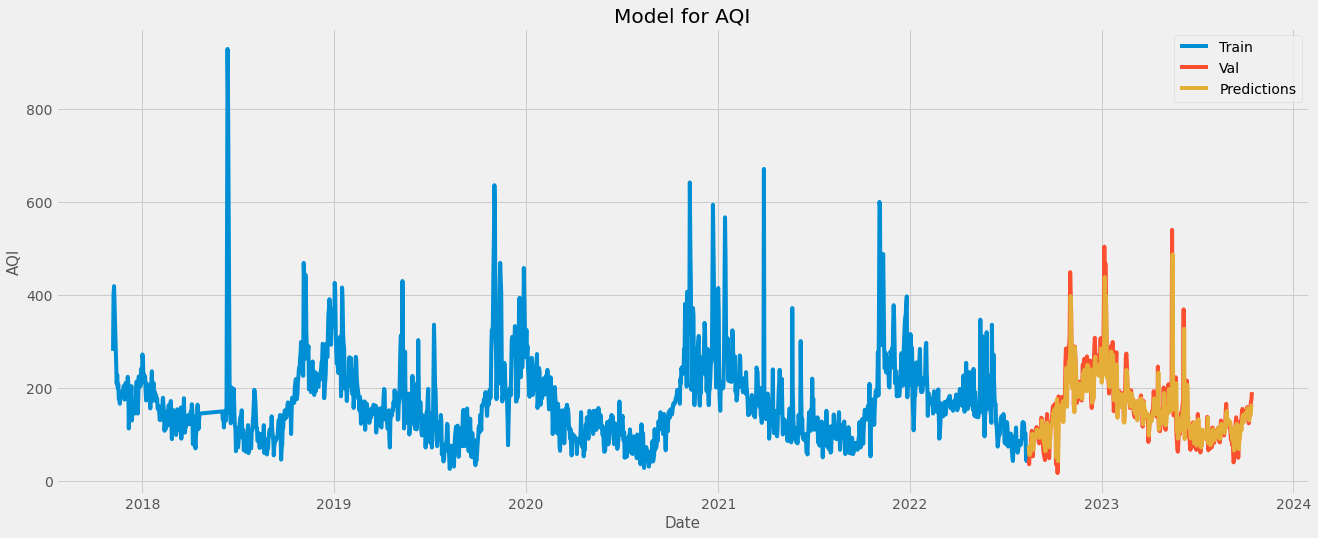

In [143]:
plt.figure(figsize=(20,8))
plt.title("Model for AQI")
plt.xlabel("Date", fontsize = 15)
plt.ylabel("AQI",fontsize=15)
plt.plot(train[df_date.columns])
plt.plot(valid['AQI'])
plt.plot(valid["Predictions"])
plt.legend(["Train","Val","Predictions"])

date     0
 pm25    0
 pm10    0
 o3      0
 no2     0
 so2     0
 co      0
dtype: int64
           date        pm25    pm10    o3   no2        so2       co  \
0    2023-10-01  149.000000  115.00   8.0  13.0   1.000000   8.0000   
1    2023-10-02  142.000000  132.00   6.0  16.0   1.000000  10.0000   
2    2023-10-03  139.000000  149.00   8.0  18.0   1.000000  11.0000   
3    2023-10-04  145.000000  143.00   7.0  17.0   1.000000  10.0000   
4    2023-10-05  159.000000  137.00   5.0  17.0   1.000000  10.0000   
...         ...         ...     ...   ...   ...        ...      ...   
2097 2018-06-02  149.678571   87.00  56.0  11.0  10.000000   7.0000   
2098 2017-12-31  180.200000  212.00  37.0  14.0   5.688589  11.5776   
2099 2017-11-06  209.210526  280.00  12.0   7.0   5.688589  11.5776   
2100 2017-11-13  209.210526  189.00  29.0  21.0   5.688589  11.5776   
2101 2020-05-10  118.833333   83.25  49.0  10.0   5.688589   6.0000   

             AQI  
0     149.000000  
1     142.000000  


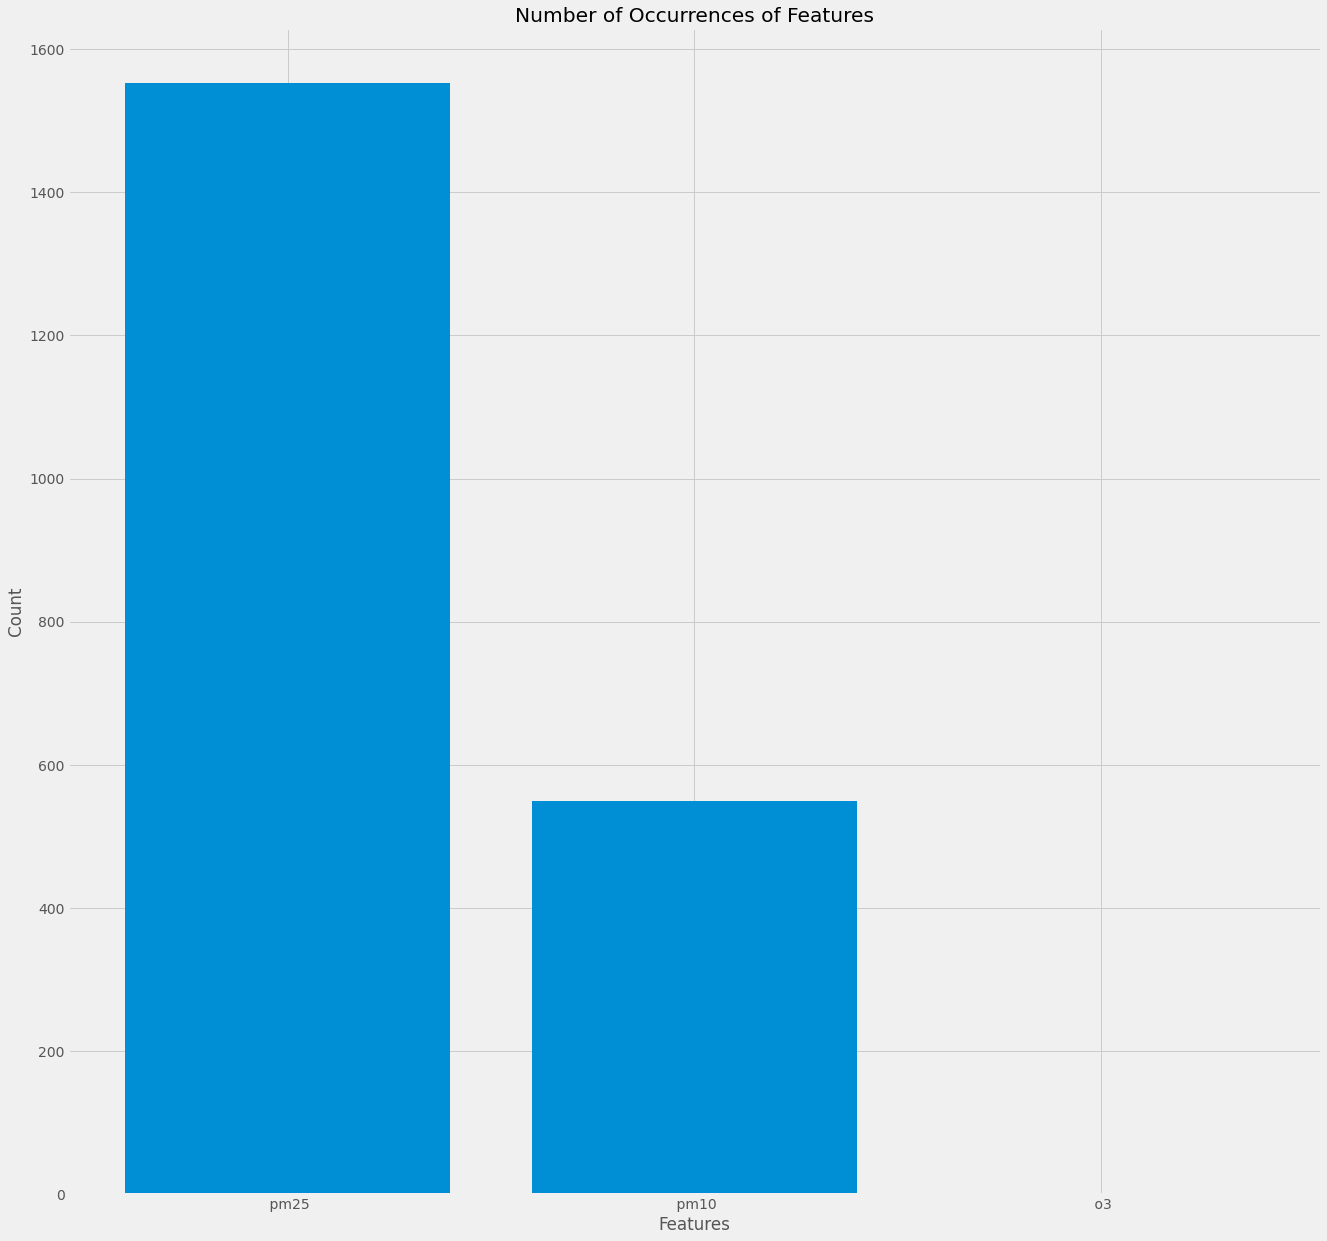

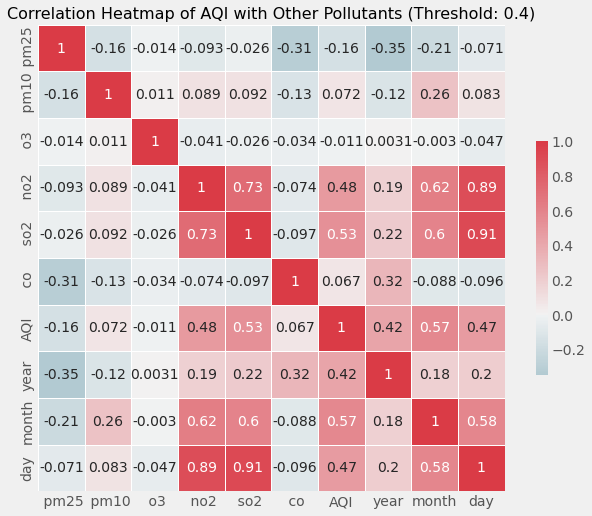

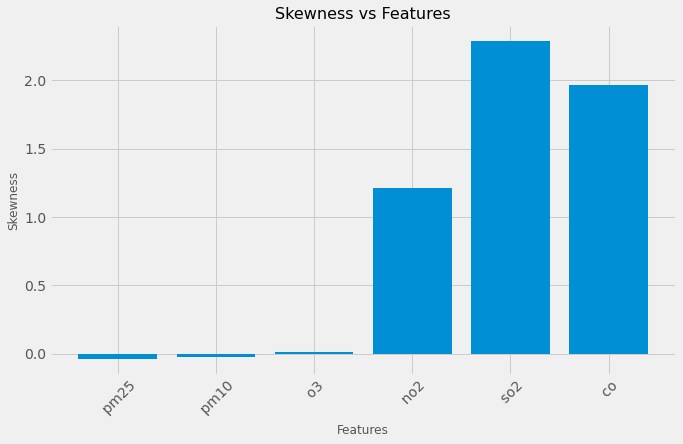

           date        pm25    pm10    o3   no2        so2       co  \
2101 2020-05-10  118.833333   83.25  49.0  10.0   5.688589   6.0000   
2100 2017-11-13  209.210526  189.00  29.0  21.0   5.688589  11.5776   
2099 2017-11-06  209.210526  280.00  12.0   7.0   5.688589  11.5776   
2098 2017-12-31  180.200000  212.00  37.0  14.0   5.688589  11.5776   
2097 2018-06-02  149.678571   87.00  56.0  11.0  10.000000   7.0000   
...         ...         ...     ...   ...   ...        ...      ...   
4    2023-10-05  159.000000  137.00   5.0  17.0   1.000000  10.0000   
3    2023-10-04  145.000000  143.00   7.0  17.0   1.000000  10.0000   
2    2023-10-03  139.000000  149.00   8.0  18.0   1.000000  11.0000   
1    2023-10-02  142.000000  132.00   6.0  16.0   1.000000  10.0000   
0    2023-10-01  149.000000  115.00   8.0  13.0   1.000000   8.0000   

             AQI  year  month  day  
2101  118.833333  2020      5   10  
2100  209.210526  2017     11   13  
2099  280.000000  2017     11    6  

date        pm25    pm10    o3   no2        so2       co  \
2101 2020-05-10  118.833333   83.25  49.0  10.0   5.688589   6.0000   
2100 2017-11-13  209.210526  189.00  29.0  21.0   5.688589  11.5776   
2099 2017-11-06  209.210526  280.00  12.0   7.0   5.688589  11.5776   
2098 2017-12-31  180.200000  212.00  37.0  14.0   5.688589  11.5776   
2097 2018-06-02  149.678571   87.00  56.0  11.0  10.000000   7.0000   
...         ...         ...     ...   ...   ...        ...      ...   
4    2023-10-05  159.000000  137.00   5.0  17.0   1.000000  10.0000   
3    2023-10-04  145.000000  143.00   7.0  17.0   1.000000  10.0000   
2    2023-10-03  139.000000  149.00   8.0  18.0   1.000000  11.0000   
1    2023-10-02  142.000000  132.00   6.0  16.0   1.000000  10.0000   
0    2023-10-01  149.000000  115.00   8.0  13.0   1.000000   8.0000   

             AQI  year  month  day  
2101  118.833333  2020      5   10  
2100  209.210526  2017     11   13  
2099  280.000000  2017     11    6  
2098  212.000000  2017     12   31  
2097  149.678571  2018      6    2  
...          ...   ...    ...  ...  
4     159.000000  2023     10    5  
3     145.000000  2023     10    4  
2     149.000000  2023     10    3  
1     142.000000  2023     10    2  
0     149.000000  2023     10    1  

[2102 rows x 11 columns]

In [144]:
df = pd.read_csv("/Users/dhruv/Dhruv/sem_5/GIS/Review Paper/Research/pusa,-delhi, delhi, india-air-quality.csv", na_values=['NA', 'N/A', ' ', ''])

df['date'] = pd.to_datetime(df['date'])

# Group data by 6-month periods
df['6_month_group'] = df['date'].dt.to_period('6M')

columns_to_fill = [' pm25',' pm10', ' o3', ' no2', ' so2', ' co']  
def fill_nan_with_mean(group):
    for col in columns_to_fill:
        if group[col].isnull().sum() == len(group):
            group[col].fillna(df[col].mean(), inplace=True)
        else:
            group[col].fillna(group[col].mean(), inplace=True)
    return group


df = df.groupby('6_month_group').apply(fill_nan_with_mean)

df.drop('6_month_group', axis=1, inplace=True)

print(df.isnull().sum())
df['AQI'] = df[columns_to_fill].max(axis=1)
print(df)

d = dict(zip(df['date'], df[columns_to_fill].idxmax(axis=1)))
feature_count = {}
for value in d.values():
    feature_count[value] = feature_count.get(value, 0) + 1

# Plotting the bar graph
plt.bar(feature_count.keys(), feature_count.values())
plt.xlabel('Features')
plt.ylabel('Count')
plt.title('Number of Occurrences of Features')
plt.show()

df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['year', 'month', 'day',' pm25',' pm10', ' o3', ' no2', ' so2', ' co','AQI']])
df_scaled = pd.DataFrame(scaled_features, columns=df.columns[1:])

# Statistical Correlation
correlation_matrix = df_scaled.corr()
f, ax = plt.subplots(figsize=(10, 8))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(correlation_matrix, cmap=cmap, vmax=1, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap of AQI with Other Pollutants (Threshold: 0.4)', fontsize=16)
plt.show()

# Skewness Identification
skewness = df_scaled.drop(['day', 'month', 'year','AQI'], axis=1).skew()

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.bar(skewness.index, skewness.values)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Skewness', fontsize=12)
plt.title('Skewness vs Features', fontsize=16)
plt.xticks(rotation=45)
plt.show()

# Printing the results
# print("Scaled Data:")
# print(df_scaled.head())

# print("\nCorrelation Matrix:")
# print(correlation_matrix)

# print("\nSkewness:")
# print(skewness) 
df = df.iloc[::-1]
print(df)

X = df[['year', 'month', 'day',' pm25',' pm10', ' o3', ' no2', ' so2', ' co']]
y = df['AQI']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the model
reg = LinearRegression()
reg.fit(X_train, y_train)

# Make predictions
y_pred = reg.predict(X_test)


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(r2)
print(rmse)

model_r2_score_list.append(r2)
model_error_list.append(rmse)

explainer = lime_tabular.LimeTabularExplainer(X_train, feature_names=X.columns, class_names=['AQI'], mode='regression')

# Choose a data point to explain
data_point_to_explain = X_test[0]

# Explain the prediction
explanation = explainer.explain_instance(data_point_to_explain, reg.predict, num_features=6)
explanation.show_in_notebook()

df


In [154]:
# pusa,-delhi, delhi, india-air-quality

X = df[[' pm25',' pm10', ' o3', ' no2', ' so2', ' co']]
y = df['AQI']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize the ANN for regression
model = Sequential()
model.add(Dense(12, input_dim=6, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))  # Output layer for regression

# Compile the ANN
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the ANN to the training data
history = model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test))

# Evaluate the ANN on the testing data
# loss = model.evaluate(X_test, y_test, verbose=0)
# print('Mean Squared Error: ', loss)

loss = model.evaluate(X_test, y_test, verbose=0)
y_pred = model.predict(X_test)

# Calculate additional regression metrics

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print('Mean Absolute Error:', rmse)
print('R-squared (R²):', r2)

model_r2_score_list.append(r2)
model_error_list.append(rmse)



# Create an explainer
explainer = lime_tabular.LimeTabularExplainer(X_train, feature_names=X.columns, class_names=['AQI'], mode='regression')

# Choose a data point to explain
data_point_to_explain = X_test[0]

# Explain the prediction
explanation = explainer.explain_instance(data_point_to_explain, model.predict, num_features=6)
explanation.show_in_notebook()

Epoch 1/150
53/53 [==============================] - 0s 1ms/step - loss: 34639.8828 - val_loss: 36338.1016
Epoch 2/150
53/53 [==============================] - 0s 722us/step - loss: 34359.3750 - val_loss: 35964.3320
Epoch 3/150
53/53 [==============================] - 0s 640us/step - loss: 33870.5156 - val_loss: 35300.9844
Epoch 4/150
53/53 [==============================] - 0s 613us/step - loss: 33070.5977 - val_loss: 34220.2617
Epoch 5/150
53/53 [==============================] - 0s 627us/step - loss: 31808.1348 - val_loss: 32598.2734
Epoch 6/150
53/53 [==============================] - 0s 620us/step - loss: 29915.2344 - val_loss: 30197.5234
Epoch 7/150
53/53 [==============================] - 0s 618us/step - loss: 27311.1309 - val_loss: 26994.5977
Epoch 8/150
53/53 [==============================] - 0s 638us/step - loss: 24016.2754 - val_loss: 23128.2598
Epoch 9/150
53/53 [==============================] - 0s 720us/step - loss: 20261.1777 - val_loss: 19028.1426
Epoch 10/150
53/53 [=

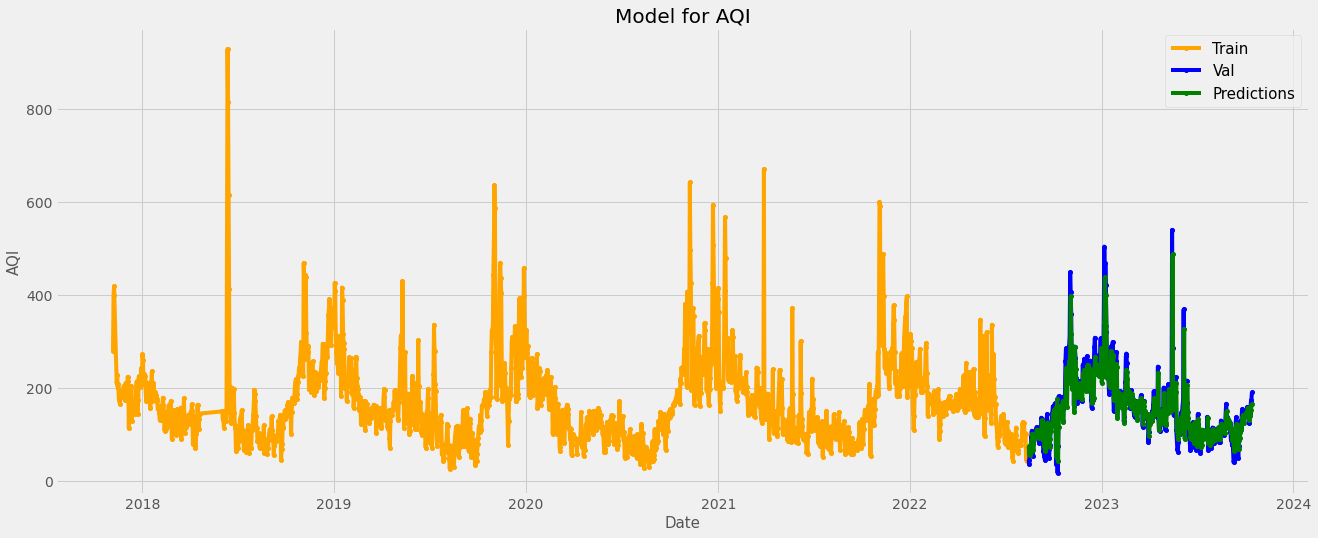

In [155]:
plt.figure(figsize=(20, 8))
plt.title("Model for AQI", fontsize=20)
plt.xlabel("Date", fontsize=15)
plt.ylabel("AQI", fontsize=15)

# Plot the training data
plt.plot(train.index, train['AQI'], label="Train", linestyle='-', marker='o', markersize=4, color='orange')

# Plot the validation (test) data
plt.plot(valid.index, valid['AQI'], label="Val", linestyle='-', marker='o', markersize=4, color='blue')

# Plot the model's predictions for the validation data
plt.plot(valid.index, valid['Predictions'], label="Predictions", linestyle='-', marker='o', markersize=4, color='green')

plt.legend(fontsize=15)
plt.grid(True)
plt.show()


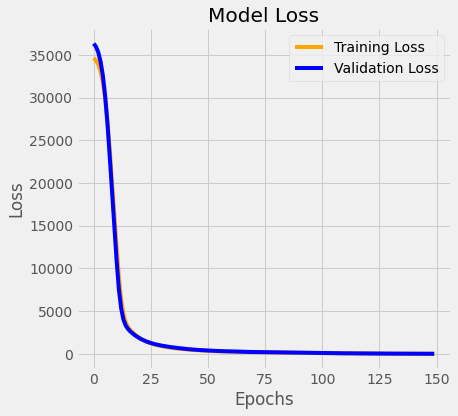

In [156]:
import matplotlib.pyplot as plt

# Assuming you have trained an ANN model and stored its history in 'history'
# For example, you can train your model like this:
# history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test))

# Plot the loss curve
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy curve (if applicable)
if 'accuracy' in history.history and 'val_accuracy' in history.history:
    plt.subplot(122)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# pusa,-delhi, delhi, india-air-quality
X = df[['year', 'month', 'day',' pm25',' pm10', ' o3', ' no2', ' so2', ' co']]
y = df['AQI']
# print(df)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the Support Vector Regressor
svr = SVR()
svr.fit(X_train, y_train)

# Make predictions
y_pred = svr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(r2)
print(rmse)

model_r2_score_list.append(r2)
model_error_list.append(rmse)


# Create an explainer
explainer = lime_tabular.LimeTabularExplainer(X_train, feature_names=X.columns, class_names=['AQI'], mode='regression')

# Choose a data point to explain
data_point_to_explain = X_test[0]

# Explain the prediction
explanation = explainer.explain_instance(data_point_to_explain, svr.predict, num_features=6)
explanation.show_in_notebook()

0.5934397562811167
56.47451923927529


In [ ]:
df

date        pm25    pm10    o3   no2        so2       co  \
2101 2020-05-10  118.833333   83.25  49.0  10.0   5.688589   6.0000   
2100 2017-11-13  209.210526  189.00  29.0  21.0   5.688589  11.5776   
2099 2017-11-06  209.210526  280.00  12.0   7.0   5.688589  11.5776   
2098 2017-12-31  180.200000  212.00  37.0  14.0   5.688589  11.5776   
2097 2018-06-02  149.678571   87.00  56.0  11.0  10.000000   7.0000   
...         ...         ...     ...   ...   ...        ...      ...   
4    2023-10-05  159.000000  137.00   5.0  17.0   1.000000  10.0000   
3    2023-10-04  145.000000  143.00   7.0  17.0   1.000000  10.0000   
2    2023-10-03  139.000000  149.00   8.0  18.0   1.000000  11.0000   
1    2023-10-02  142.000000  132.00   6.0  16.0   1.000000  10.0000   
0    2023-10-01  149.000000  115.00   8.0  13.0   1.000000   8.0000   

             AQI  year  month  day  
2101  118.833333  2020      5   10  
2100  209.210526  2017     11   13  
2099  280.000000  2017     11    6  
2098  212.000000  2017     12   31  
2097  149.678571  2018      6    2  
...          ...   ...    ...  ...  
4     159.000000  2023     10    5  
3     145.000000  2023     10    4  
2     149.000000  2023     10    3  
1     142.000000  2023     10    2  
0     149.000000  2023     10    1  

[2102 rows x 11 columns]

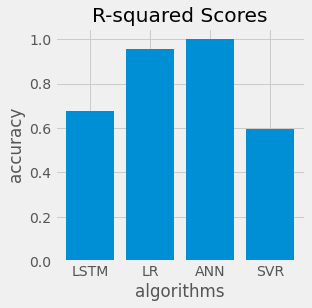

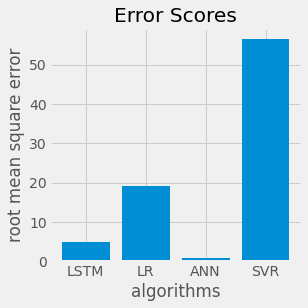

[0.675573531258408, 0.9536384716790359, 0.999931697144387, 0.5934397562811167]
[4.977276113753864, 19.070802149321306, 0.7319973672206126, 56.47451923927529]


In [ ]:
import matplotlib.pyplot as plt

algos = ['LSTM', 'LR', 'ANN', 'SVR']


plt.figure(figsize=(4, 4))
plt.bar(algos, model_r2_score_list)
plt.title('R-squared Scores')
plt.xlabel('algorithms')
plt.ylabel('accuracy')
plt.show()

plt.figure(figsize=(4, 4))
plt.bar(algos, model_error_list)
plt.title('Error Scores')
plt.xlabel('algorithms')
plt.ylabel('root mean square error')
plt.show()

print(model_r2_score_list)
print(model_error_list)
